# DCGAN

1. Load libraries
2. CelebA/CIFAR-10/MNIST dataset download 
3. Random sample $z$ from normal distribution
4. Generative model $G$
5. Disciminative model $D$
6. Train model $G$ and $D$
   1. Initialize model \\(G\\) and \\(D\\)
   2. Loss functions & Optimizers
   3. Train models
   4. Save model weights
7. Visualization (Interpolation)



- **Current: Unstable training**

## 1. Load libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import torchvision
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

In [2]:
print('numpy: ' + np.__version__)
print('pandas: ' + pd.__version__)
print('matlotlib: ' + matplotlib.__version__)
print('torch: ' + torch.__version__)
print('torchvision: ' + torchvision.__version__)

numpy: 1.16.0
pandas: 0.25.3
matlotlib: 3.0.3
torch: 1.5.1
torchvision: 0.6.1


In [3]:
import random

# Set random seed for reproducibility
manualSeed = 2020
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed);

Random Seed:  2020


In [4]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

print(device)

cuda


## 2. CIFAR-10 dataset download 
- No pre-processing was applied to training images besides scaling to the range of the tanh activation
function [-1, 1].
- All models were trained with mini-batch stochastic gradient descent (SGD) with
a mini-batch size of 128.

In [5]:
image_size = 64
batch_size = 64

In [6]:
# standardizer
standardizer = transforms.Compose([
                                    transforms.Resize(image_size),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=(0.5, 0.5, 0.5),
                                                        std=(0.5, 0.5, 0.5))])

# CIFAR_10 dataset
train_data = dsets.CIFAR10(root='../data/', train=True, transform=standardizer, download=True)

Files already downloaded and verified


In [7]:
# standardizer
standardizer = transforms.Compose([
                                    transforms.Resize(image_size),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=0.5,
                                                        std=0.5)])

# CIFAR_10 dataset
train_data = dsets.MNIST(root='../data/', train=True, transform=standardizer, download=True)

In [8]:
# Data loader
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)

In [9]:
# function for visualization
def tc_imshow(img, lbl=""):
    if img.size(0) == 1:
        plt.imshow(img.squeeze(), cmap='gray')
    else:
        plt.imshow(np.transpose(img, (1, 2, 0)))
        
    plt.title(lbl)
    plt.axis('off')

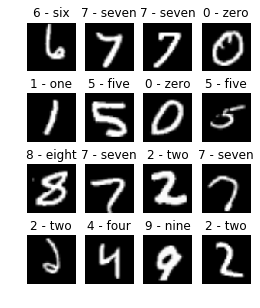

In [10]:
# visualize
mini_batch_img, mini_batch_lbl = next(iter(train_data_loader))

plt.figure(figsize=(4,5))
for i in range(16):
    plt.subplot(4,4,i+1)
    tc_imshow(img=mini_batch_img[i] /2+0.5 ,
              lbl=train_data.classes[mini_batch_lbl[i].numpy()])
    plt.axis('off')
    
plt.savefig('../result/GAN/2-DCGAN/1-dataloader-example.png', dpi=300)

> 📌 **NOTE**  
>  
> - Downloaded MNIST/CIFAR-10 images from server  
> - Upscaled images to 64X64 from 32X32
> - Created dataloader for MNIST images

## 3. Random sample $z$ from uniform distribution

- z 를 random sampling 할 때, 100x1이 아니라 100x1x1로 sampling 하는게 중요함 (project and reshape 과정을 z sampling에서 한번에 해버림)

In [11]:
dim_noise = 100

In [12]:
# Random sampling from normal distribution
def random_sample_z_space(batch_size=1, dim_noise=100):
    return torch.randn(batch_size, dim_noise, 1, 1, device=device)

In [13]:
# # Random sampling from uniform distribution
# def random_sample_z_space(batch_size=1, dim_noise=100):
#     return torch.rand(batch_size, dim_noise, 1, 1, device=device)

In [14]:
# Random sampling
z = random_sample_z_space(batch_size)

print("z\t:{}".format(z.shape))

z	:torch.Size([64, 100, 1, 1])


> 📌 **NOTE**  
>  
> Random noise를 성공적으로 샘플링했다 !

## 4. Generative model $G$

![DCGAN 구조 핵심](https://tyami.github.io/assets/images/post/DL/2020-10-17-GAN-DCGAN-theory/2020-10-17-GAN-DCGAN-theory-9-DCGAN-key-concept.png)

![DCGAN G 구조](https://tyami.github.io/assets/images/post/DL/2020-10-17-GAN-DCGAN-theory/2020-10-17-GAN-DCGAN-theory-10-DCGAN-G-model.png)

- All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02
- 100x1 (100x1x1) → 1024x4x4 → 512x8x8 → 256x16x16 → 128x32x32 → 3x64x64

In [15]:
# hyper-parameters
dim_G_last2_channel = 64
dim_output = mini_batch_img.size(1)

In [16]:
def initialize_weights(model):
    class_names = model.__class__.__name__
    
    if class_names.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
        
    elif class_names.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

In [17]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
                    # 100x1 z 1D vector에서 2D vector로의 변환이 없는 이유: 애초에 z random sampling 시 1x1 matrix 형태로 sampling 하면 됨.
                    nn.ConvTranspose2d(in_channels=dim_noise, 
                                       out_channels=dim_G_last2_channel*8, 
                                       kernel_size=4, # 어떻게 정해진거지?
                                       stride=1,
                                       padding=0, # 어떻게 정해진거지?
                                       bias=False),
                    nn.BatchNorm2d(dim_G_last2_channel*8),
                    nn.ReLU(True),
            
                    nn.ConvTranspose2d(in_channels=dim_G_last2_channel*8, 
                                       out_channels=dim_G_last2_channel*4, 
                                       kernel_size=4, # 어떻게 정해진거지?
                                       stride=2,
                                       padding=1, # 어떻게 정해진거지?
                                       bias=False),
                    nn.BatchNorm2d(dim_G_last2_channel*4),
                    nn.ReLU(True),
            
                    nn.ConvTranspose2d(in_channels=dim_G_last2_channel*4, 
                                       out_channels=dim_G_last2_channel*2, 
                                       kernel_size=4, # 어떻게 정해진거지?
                                       stride=2,
                                       padding=1, # 어떻게 정해진거지?
                                       bias=False),
                    nn.BatchNorm2d(dim_G_last2_channel*2),
                    nn.ReLU(True),
            
                    nn.ConvTranspose2d(in_channels=dim_G_last2_channel*2, 
                                       out_channels=dim_G_last2_channel, 
                                       kernel_size=4, # 어떻게 정해진거지?
                                       stride=2,
                                       padding=1, # 어떻게 정해진거지?
                                       bias=False),
                    nn.BatchNorm2d(dim_G_last2_channel),
                    nn.ReLU(True),

                    nn.ConvTranspose2d(in_channels=dim_G_last2_channel, 
                                       out_channels=dim_output, 
                                       kernel_size=4, # 어떻게 정해진거지?
                                       stride=2,
                                       padding=1, # 어떻게 정해진거지?
                                       bias=False),
                    nn.Tanh()
        )
    def forward(self, z):
        img = self.model(z)
        
        return img

In [18]:
# Create the generator
G = Generator().to(device)

# weight initialize
G.apply(initialize_weights) 

# Size check
print("z\t:{}".format(z.shape))
print("G(z)\t:{}".format(G(z).size()))

z	:torch.Size([64, 100, 1, 1])
G(z)	:torch.Size([64, 1, 64, 64])


In [19]:
# visualize
utils.save_image(G(z)[:25].cpu().detach(), "../result/GAN/2-DCGAN/2-G(z).png", nrow=5, normalize=True)

> 📌 **NOTE**  
>  
> - Defined generative model $G$
> - Because generator $G$ is not trained yet, $G(z)$ produces meaningless noisy images

## 5. Disciminative model $D$

- In the LeakyReLU, the slope of the leak was set to 0.2 in all models.
- 3x64x64 → 128x32x32 → 256x16x16 → 512x8x8 → 1024x4x4 → 1 (1x1x1)
- kernel_size, stride, padding 모두 $G$의 반대로

In [20]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=dim_output,
                      out_channels=dim_G_last2_channel,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(dim_G_last2_channel),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(in_channels=dim_G_last2_channel,
                      out_channels=dim_G_last2_channel*2,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(dim_G_last2_channel*2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(in_channels=dim_G_last2_channel*2,
                      out_channels=dim_G_last2_channel*4,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(dim_G_last2_channel*4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(in_channels=dim_G_last2_channel*4,
                      out_channels=dim_G_last2_channel*8,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(dim_G_last2_channel*8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(in_channels=dim_G_last2_channel*8,
                      out_channels=1,
                      kernel_size=4,
                      stride=1,
                      padding=0,
                      bias=False),
            nn.Sigmoid()
        )
        
    
    def forward(self, img):
        check_validity = self.model(img)
        
        return check_validity

In [21]:
D = Discriminator().to(device)
D.apply(initialize_weights)

print("z\t:{}".format(z.shape))
print("G(z)\t:{}".format(G(z).size()))
print("D(G(z))\t:{}".format(D(G(z)).size()))

z	:torch.Size([64, 100, 1, 1])
G(z)	:torch.Size([64, 1, 64, 64])
D(G(z))	:torch.Size([64, 1, 1, 1])


> 📌 **NOTE**  
>  
> Defined discriminative model $D$ which architecture is like innverse of generative model $G$  
> The output of $D$ is a sigmoid function to discriminate fake and real image

## 6. Train model $G$ and $D$
- We found the suggested learning rate of 0.001, to be too high, using 0.0002 instead. 
- we found leaving the momentum term $\beta_1$ at the suggested value of 0.9 resulted in training oscillation and instability while reducing it to 0.5 helped stabilize training.

### 6-1. Initialize models

In [22]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

generator.apply(initialize_weights)
discriminator.apply(initialize_weights);

### 6-2. Loss function & optimizers

In [23]:
# hyper-parameters
learning_rate = 0.0002
beta1 = 0.5

In [24]:
adversarial_loss = nn.BCELoss()

In [25]:
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(beta1, 0.999))

### 6-3. Train models

In [26]:
# hyper-parameters
num_epochs = 200
interval_save_img = 1000

In [27]:
Tensor = torch.cuda.FloatTensor if is_cuda else torch.FloatTensor

In [ ]:
losses = []

for idx_epoch in range(num_epochs):
    for idx_batch, (imgs, _) in enumerate(train_data_loader):
        # Ground truth variables indicating real/fake
        real_ground_truth = Variable(Tensor(imgs.size(0), 1, 1, 1).fill_(1.0), requires_grad=False)
        fake_ground_truth = Variable(Tensor(imgs.size(0), 1, 1, 1).fill_(0.0), requires_grad=False) 
        
        # Real image
        real_imgs = Variable(imgs.type(Tensor))
                
        #####################
        # Train Generator
        
        optimizer_G.zero_grad()
        
        # Random sample noise
        z = random_sample_z_space(imgs.size(0))

        # Generate image
        gen_imgs = generator(z)
        
        # Generator's loss: loss between D(G(z)) and real ground truth
        loss_G = adversarial_loss(discriminator(gen_imgs), real_ground_truth)
        
        loss_G.backward()
        optimizer_G.step()
        
        
        #####################
        # Train Discriminator
        
        optimizer_D.zero_grad()
        
        loss_real = adversarial_loss(discriminator(real_imgs), real_ground_truth)
        loss_fake = adversarial_loss(discriminator(gen_imgs.detach()), fake_ground_truth)
        loss_D = (loss_real+loss_fake)/2
        
        loss_D.backward()
        optimizer_D.step()
        
        
        #####################
        # archieve loss
        losses.append([loss_G.item(), loss_D.item()])
        
        # Print progress
        if idx_batch % 10 == 0:
            print("[Epoch {}/{}] [Batch {}/{}] loss_G: {:.6f}, loss_D: {:.6f}".format(idx_epoch, num_epochs,
                                                                                      idx_batch, len(train_data_loader),
                                                                                      loss_G, loss_D))
                    
        batches_done = idx_epoch * len(train_data_loader) + idx_batch
        if batches_done % interval_save_img == 0:
            utils.save_image(gen_imgs.data[:25], "../result/GAN/2-DCGAN/3-{}.png".format(batches_done), nrow=5, normalize=True)

[Epoch 0/200] [Batch 0/938] loss_G: 1.136137, loss_D: 0.762778
[Epoch 0/200] [Batch 10/938] loss_G: 4.168915, loss_D: 0.027409
[Epoch 0/200] [Batch 20/938] loss_G: 10.649624, loss_D: 0.010442
[Epoch 0/200] [Batch 30/938] loss_G: 3.993680, loss_D: 0.014640
[Epoch 0/200] [Batch 40/938] loss_G: 37.805130, loss_D: 0.000904
[Epoch 0/200] [Batch 50/938] loss_G: 38.561604, loss_D: 0.000066
[Epoch 0/200] [Batch 60/938] loss_G: 38.516865, loss_D: 0.000106
[Epoch 0/200] [Batch 70/938] loss_G: 38.537178, loss_D: 0.000018
[Epoch 0/200] [Batch 80/938] loss_G: 38.482456, loss_D: 0.000046
[Epoch 0/200] [Batch 90/938] loss_G: 38.378983, loss_D: 0.000047
[Epoch 0/200] [Batch 100/938] loss_G: 38.309242, loss_D: 0.000032
[Epoch 0/200] [Batch 110/938] loss_G: 38.380867, loss_D: 0.000029
[Epoch 0/200] [Batch 120/938] loss_G: 38.412029, loss_D: 0.000021
[Epoch 0/200] [Batch 130/938] loss_G: 38.361282, loss_D: 0.000025
[Epoch 0/200] [Batch 140/938] loss_G: 38.336365, loss_D: 0.000016
[Epoch 0/200] [Batch 150

[Epoch 1/200] [Batch 310/938] loss_G: 44.554802, loss_D: 0.000007
[Epoch 1/200] [Batch 320/938] loss_G: 44.666233, loss_D: 0.000004
[Epoch 1/200] [Batch 330/938] loss_G: 44.606785, loss_D: 0.000005
[Epoch 1/200] [Batch 340/938] loss_G: 44.174896, loss_D: 0.000016
[Epoch 1/200] [Batch 350/938] loss_G: 44.624439, loss_D: 0.000001
[Epoch 1/200] [Batch 360/938] loss_G: 44.652561, loss_D: 0.000005
[Epoch 1/200] [Batch 370/938] loss_G: 44.442711, loss_D: 0.000008
[Epoch 1/200] [Batch 380/938] loss_G: 44.219139, loss_D: 0.000003
[Epoch 1/200] [Batch 390/938] loss_G: 44.381069, loss_D: 0.000008
[Epoch 1/200] [Batch 400/938] loss_G: 44.564003, loss_D: 0.000005
[Epoch 1/200] [Batch 410/938] loss_G: 44.642288, loss_D: 0.000006
[Epoch 1/200] [Batch 420/938] loss_G: 44.558407, loss_D: 0.000005
[Epoch 1/200] [Batch 430/938] loss_G: 44.563084, loss_D: 0.000008
[Epoch 1/200] [Batch 440/938] loss_G: 44.809669, loss_D: 0.000004
[Epoch 1/200] [Batch 450/938] loss_G: 44.799469, loss_D: 0.000005
[Epoch 1/2

[Epoch 2/200] [Batch 620/938] loss_G: 44.547043, loss_D: 0.000003
[Epoch 2/200] [Batch 630/938] loss_G: 44.676643, loss_D: 0.000005
[Epoch 2/200] [Batch 640/938] loss_G: 44.738342, loss_D: 0.000001
[Epoch 2/200] [Batch 650/938] loss_G: 44.541191, loss_D: 0.000001
[Epoch 2/200] [Batch 660/938] loss_G: 44.568764, loss_D: 0.000001
[Epoch 2/200] [Batch 670/938] loss_G: 44.834763, loss_D: 0.000004
[Epoch 2/200] [Batch 680/938] loss_G: 44.754021, loss_D: 0.000002
[Epoch 2/200] [Batch 690/938] loss_G: 44.336681, loss_D: 0.000001
[Epoch 2/200] [Batch 700/938] loss_G: 44.811077, loss_D: 0.000001
[Epoch 2/200] [Batch 710/938] loss_G: 44.562256, loss_D: 0.000001
[Epoch 2/200] [Batch 720/938] loss_G: 44.764652, loss_D: 0.000001
[Epoch 2/200] [Batch 730/938] loss_G: 44.655739, loss_D: 0.000002
[Epoch 2/200] [Batch 740/938] loss_G: 44.732941, loss_D: 0.000002
[Epoch 2/200] [Batch 750/938] loss_G: 44.761475, loss_D: 0.000002
[Epoch 2/200] [Batch 760/938] loss_G: 44.363876, loss_D: 0.000001
[Epoch 2/2

[Epoch 3/200] [Batch 930/938] loss_G: 44.681381, loss_D: 0.000001
[Epoch 4/200] [Batch 0/938] loss_G: 44.792160, loss_D: 0.000000
[Epoch 4/200] [Batch 10/938] loss_G: 44.932045, loss_D: 0.000000
[Epoch 4/200] [Batch 20/938] loss_G: 44.533070, loss_D: 0.000002
[Epoch 4/200] [Batch 30/938] loss_G: 44.549770, loss_D: 0.000003
[Epoch 4/200] [Batch 40/938] loss_G: 44.873131, loss_D: 0.000001
[Epoch 4/200] [Batch 50/938] loss_G: 44.791313, loss_D: 0.000000
[Epoch 4/200] [Batch 60/938] loss_G: 44.499866, loss_D: 0.000002
[Epoch 4/200] [Batch 70/938] loss_G: 44.823860, loss_D: 0.000001
[Epoch 4/200] [Batch 80/938] loss_G: 44.923752, loss_D: 0.000001
[Epoch 4/200] [Batch 90/938] loss_G: 44.915321, loss_D: 0.000002
[Epoch 4/200] [Batch 100/938] loss_G: 44.598450, loss_D: 0.000000
[Epoch 4/200] [Batch 110/938] loss_G: 44.507328, loss_D: 0.000000
[Epoch 4/200] [Batch 120/938] loss_G: 44.581417, loss_D: 0.000002
[Epoch 4/200] [Batch 130/938] loss_G: 44.582809, loss_D: 0.000001
[Epoch 4/200] [Batch 

[Epoch 5/200] [Batch 300/938] loss_G: 44.640381, loss_D: 0.000001
[Epoch 5/200] [Batch 310/938] loss_G: 44.750099, loss_D: 0.000001
[Epoch 5/200] [Batch 320/938] loss_G: 44.884926, loss_D: 0.000000
[Epoch 5/200] [Batch 330/938] loss_G: 44.774284, loss_D: 0.000000
[Epoch 5/200] [Batch 340/938] loss_G: 44.738224, loss_D: 0.000001
[Epoch 5/200] [Batch 350/938] loss_G: 44.608143, loss_D: 0.000000
[Epoch 5/200] [Batch 360/938] loss_G: 44.507763, loss_D: 0.000002
[Epoch 5/200] [Batch 370/938] loss_G: 44.905064, loss_D: 0.000000
[Epoch 5/200] [Batch 380/938] loss_G: 44.640186, loss_D: 0.000000
[Epoch 5/200] [Batch 390/938] loss_G: 44.604645, loss_D: 0.000000
[Epoch 5/200] [Batch 400/938] loss_G: 44.802856, loss_D: 0.000000
[Epoch 5/200] [Batch 410/938] loss_G: 44.849571, loss_D: 0.000000
[Epoch 5/200] [Batch 420/938] loss_G: 44.613560, loss_D: 0.000001
[Epoch 5/200] [Batch 430/938] loss_G: 44.795620, loss_D: 0.000000
[Epoch 5/200] [Batch 440/938] loss_G: 44.654751, loss_D: 0.000000
[Epoch 5/2

[Epoch 6/200] [Batch 610/938] loss_G: 44.901775, loss_D: 0.000001
[Epoch 6/200] [Batch 620/938] loss_G: 44.738930, loss_D: 0.000000
[Epoch 6/200] [Batch 630/938] loss_G: 44.717255, loss_D: 0.000000
[Epoch 6/200] [Batch 640/938] loss_G: 44.851833, loss_D: 0.000000
[Epoch 6/200] [Batch 650/938] loss_G: 44.491287, loss_D: 0.000000
[Epoch 6/200] [Batch 660/938] loss_G: 44.953613, loss_D: 0.000000
[Epoch 6/200] [Batch 670/938] loss_G: 44.778996, loss_D: 0.000001
[Epoch 6/200] [Batch 680/938] loss_G: 44.787617, loss_D: 0.000000
[Epoch 6/200] [Batch 690/938] loss_G: 44.660198, loss_D: 0.000000
[Epoch 6/200] [Batch 700/938] loss_G: 44.810875, loss_D: 0.000000
[Epoch 6/200] [Batch 710/938] loss_G: 44.875103, loss_D: 0.000000
[Epoch 6/200] [Batch 720/938] loss_G: 44.524364, loss_D: 0.000000
[Epoch 6/200] [Batch 730/938] loss_G: 45.028229, loss_D: 0.000000
[Epoch 6/200] [Batch 740/938] loss_G: 44.954575, loss_D: 0.000000
[Epoch 6/200] [Batch 750/938] loss_G: 44.688229, loss_D: 0.000000
[Epoch 6/2

[Epoch 7/200] [Batch 920/938] loss_G: 44.811672, loss_D: 0.000000
[Epoch 7/200] [Batch 930/938] loss_G: 44.624466, loss_D: 0.000000
[Epoch 8/200] [Batch 0/938] loss_G: 44.824436, loss_D: 0.000000
[Epoch 8/200] [Batch 10/938] loss_G: 44.511536, loss_D: 0.000000
[Epoch 8/200] [Batch 20/938] loss_G: 44.830132, loss_D: 0.000000
[Epoch 8/200] [Batch 30/938] loss_G: 44.672451, loss_D: 0.000000
[Epoch 8/200] [Batch 40/938] loss_G: 44.674587, loss_D: 0.000000
[Epoch 8/200] [Batch 50/938] loss_G: 44.858028, loss_D: 0.000000
[Epoch 8/200] [Batch 60/938] loss_G: 44.360779, loss_D: 0.000000
[Epoch 8/200] [Batch 70/938] loss_G: 44.403503, loss_D: 0.000000
[Epoch 8/200] [Batch 80/938] loss_G: 44.712582, loss_D: 0.000000
[Epoch 8/200] [Batch 90/938] loss_G: 44.858215, loss_D: 0.000000
[Epoch 8/200] [Batch 100/938] loss_G: 44.664822, loss_D: 0.000000
[Epoch 8/200] [Batch 110/938] loss_G: 44.992458, loss_D: 0.000000
[Epoch 8/200] [Batch 120/938] loss_G: 44.942760, loss_D: 0.000000
[Epoch 8/200] [Batch 

[Epoch 9/200] [Batch 290/938] loss_G: 44.562302, loss_D: 0.000000
[Epoch 9/200] [Batch 300/938] loss_G: 44.380573, loss_D: 0.000000
[Epoch 9/200] [Batch 310/938] loss_G: 44.738937, loss_D: 0.000000
[Epoch 9/200] [Batch 320/938] loss_G: 44.581402, loss_D: 0.000000
[Epoch 9/200] [Batch 330/938] loss_G: 44.828018, loss_D: 0.000000
[Epoch 9/200] [Batch 340/938] loss_G: 44.867340, loss_D: 0.000000
[Epoch 9/200] [Batch 350/938] loss_G: 44.621185, loss_D: 0.000000
[Epoch 9/200] [Batch 360/938] loss_G: 44.546097, loss_D: 0.000000
[Epoch 9/200] [Batch 370/938] loss_G: 44.628593, loss_D: 0.000000
[Epoch 9/200] [Batch 380/938] loss_G: 44.882423, loss_D: 0.000000
[Epoch 9/200] [Batch 390/938] loss_G: 44.796051, loss_D: 0.000000
[Epoch 9/200] [Batch 400/938] loss_G: 44.823845, loss_D: 0.000000
[Epoch 9/200] [Batch 410/938] loss_G: 44.570633, loss_D: 0.000000
[Epoch 9/200] [Batch 420/938] loss_G: 44.478588, loss_D: 0.000000
[Epoch 9/200] [Batch 430/938] loss_G: 44.728470, loss_D: 0.000000
[Epoch 9/2

[Epoch 10/200] [Batch 590/938] loss_G: 44.683655, loss_D: 0.000000
[Epoch 10/200] [Batch 600/938] loss_G: 44.641823, loss_D: 0.000000
[Epoch 10/200] [Batch 610/938] loss_G: 44.535213, loss_D: 0.000000
[Epoch 10/200] [Batch 620/938] loss_G: 44.729141, loss_D: 0.000000
[Epoch 10/200] [Batch 630/938] loss_G: 44.673943, loss_D: 0.000000
[Epoch 10/200] [Batch 640/938] loss_G: 44.797089, loss_D: 0.000000
[Epoch 10/200] [Batch 650/938] loss_G: 44.625893, loss_D: 0.000000
[Epoch 10/200] [Batch 660/938] loss_G: 44.711193, loss_D: 0.000000
[Epoch 10/200] [Batch 670/938] loss_G: 44.632633, loss_D: 0.000000
[Epoch 10/200] [Batch 680/938] loss_G: 44.745998, loss_D: 0.000000
[Epoch 10/200] [Batch 690/938] loss_G: 44.625175, loss_D: 0.000000
[Epoch 10/200] [Batch 700/938] loss_G: 44.752586, loss_D: 0.000000
[Epoch 10/200] [Batch 710/938] loss_G: 44.661205, loss_D: 0.000000
[Epoch 10/200] [Batch 720/938] loss_G: 44.704594, loss_D: 0.000000
[Epoch 10/200] [Batch 730/938] loss_G: 44.679131, loss_D: 0.00

[Epoch 11/200] [Batch 880/938] loss_G: 44.544960, loss_D: 0.000000
[Epoch 11/200] [Batch 890/938] loss_G: 44.559174, loss_D: 0.000000
[Epoch 11/200] [Batch 900/938] loss_G: 44.796978, loss_D: 0.000000
[Epoch 11/200] [Batch 910/938] loss_G: 44.717587, loss_D: 0.000000
[Epoch 11/200] [Batch 920/938] loss_G: 44.497421, loss_D: 0.000000
[Epoch 11/200] [Batch 930/938] loss_G: 44.489902, loss_D: 0.000000
[Epoch 12/200] [Batch 0/938] loss_G: 44.633778, loss_D: 0.000000
[Epoch 12/200] [Batch 10/938] loss_G: 44.648685, loss_D: 0.000000
[Epoch 12/200] [Batch 20/938] loss_G: 44.787048, loss_D: 0.000000
[Epoch 12/200] [Batch 30/938] loss_G: 44.536530, loss_D: 0.000000
[Epoch 12/200] [Batch 40/938] loss_G: 44.691647, loss_D: 0.000000
[Epoch 12/200] [Batch 50/938] loss_G: 44.720310, loss_D: 0.000000
[Epoch 12/200] [Batch 60/938] loss_G: 44.562218, loss_D: 0.000000
[Epoch 12/200] [Batch 70/938] loss_G: 44.769539, loss_D: 0.000000
[Epoch 12/200] [Batch 80/938] loss_G: 44.650398, loss_D: 0.000000
[Epoc

[Epoch 13/200] [Batch 230/938] loss_G: 44.507130, loss_D: 0.000000
[Epoch 13/200] [Batch 240/938] loss_G: 44.730621, loss_D: 0.000000
[Epoch 13/200] [Batch 250/938] loss_G: 44.667084, loss_D: 0.000000
[Epoch 13/200] [Batch 260/938] loss_G: 44.463066, loss_D: 0.000000
[Epoch 13/200] [Batch 270/938] loss_G: 44.455627, loss_D: 0.000000
[Epoch 13/200] [Batch 280/938] loss_G: 44.701054, loss_D: 0.000000
[Epoch 13/200] [Batch 290/938] loss_G: 44.794250, loss_D: 0.000000
[Epoch 13/200] [Batch 300/938] loss_G: 44.569317, loss_D: 0.000000
[Epoch 13/200] [Batch 310/938] loss_G: 44.621609, loss_D: 0.000000
[Epoch 13/200] [Batch 320/938] loss_G: 44.698753, loss_D: 0.000000
[Epoch 13/200] [Batch 330/938] loss_G: 44.647648, loss_D: 0.000000
[Epoch 13/200] [Batch 340/938] loss_G: 44.749149, loss_D: 0.000000
[Epoch 13/200] [Batch 350/938] loss_G: 44.495800, loss_D: 0.000000
[Epoch 13/200] [Batch 360/938] loss_G: 44.667099, loss_D: 0.000000
[Epoch 13/200] [Batch 370/938] loss_G: 44.434326, loss_D: 0.00

[Epoch 14/200] [Batch 520/938] loss_G: 44.821236, loss_D: 0.000000
[Epoch 14/200] [Batch 530/938] loss_G: 44.459930, loss_D: 0.000000
[Epoch 14/200] [Batch 540/938] loss_G: 44.086388, loss_D: 0.000000
[Epoch 14/200] [Batch 550/938] loss_G: 44.445034, loss_D: 0.000000
[Epoch 14/200] [Batch 560/938] loss_G: 44.188278, loss_D: 0.000000
[Epoch 14/200] [Batch 570/938] loss_G: 44.441551, loss_D: 0.000000
[Epoch 14/200] [Batch 580/938] loss_G: 44.373482, loss_D: 0.000000
[Epoch 14/200] [Batch 590/938] loss_G: 44.425503, loss_D: 0.000000
[Epoch 14/200] [Batch 600/938] loss_G: 44.166550, loss_D: 0.000000
[Epoch 14/200] [Batch 610/938] loss_G: 44.419823, loss_D: 0.000000
[Epoch 14/200] [Batch 620/938] loss_G: 44.060379, loss_D: 0.000000
[Epoch 14/200] [Batch 630/938] loss_G: 44.118999, loss_D: 0.000000
[Epoch 14/200] [Batch 640/938] loss_G: 44.385830, loss_D: 0.000000
[Epoch 14/200] [Batch 650/938] loss_G: 44.538902, loss_D: 0.000000
[Epoch 14/200] [Batch 660/938] loss_G: 44.715565, loss_D: 0.00

[Epoch 15/200] [Batch 810/938] loss_G: 44.166908, loss_D: 0.000000
[Epoch 15/200] [Batch 820/938] loss_G: 44.280106, loss_D: 0.000000
[Epoch 15/200] [Batch 830/938] loss_G: 44.066460, loss_D: 0.000000
[Epoch 15/200] [Batch 840/938] loss_G: 44.094673, loss_D: 0.000000
[Epoch 15/200] [Batch 850/938] loss_G: 44.168930, loss_D: 0.000000
[Epoch 15/200] [Batch 860/938] loss_G: 44.418438, loss_D: 0.000000
[Epoch 15/200] [Batch 870/938] loss_G: 44.223740, loss_D: 0.000000
[Epoch 15/200] [Batch 880/938] loss_G: 43.923721, loss_D: 0.000000
[Epoch 15/200] [Batch 890/938] loss_G: 44.239075, loss_D: 0.000000
[Epoch 15/200] [Batch 900/938] loss_G: 44.167374, loss_D: 0.000000
[Epoch 15/200] [Batch 910/938] loss_G: 44.144661, loss_D: 0.000000
[Epoch 15/200] [Batch 920/938] loss_G: 44.263268, loss_D: 0.000000
[Epoch 15/200] [Batch 930/938] loss_G: 44.245502, loss_D: 0.000000
[Epoch 16/200] [Batch 0/938] loss_G: 43.958553, loss_D: 0.000000
[Epoch 16/200] [Batch 10/938] loss_G: 44.148708, loss_D: 0.00000

[Epoch 17/200] [Batch 160/938] loss_G: 0.602381, loss_D: 0.607903
[Epoch 17/200] [Batch 170/938] loss_G: 2.309057, loss_D: 0.112733
[Epoch 17/200] [Batch 180/938] loss_G: 3.363192, loss_D: 0.045317
[Epoch 17/200] [Batch 190/938] loss_G: 4.241952, loss_D: 0.434578
[Epoch 17/200] [Batch 200/938] loss_G: 1.813786, loss_D: 0.253333
[Epoch 17/200] [Batch 210/938] loss_G: 2.389424, loss_D: 0.329824
[Epoch 17/200] [Batch 220/938] loss_G: 2.320727, loss_D: 0.194306
[Epoch 17/200] [Batch 230/938] loss_G: 0.871342, loss_D: 0.471926
[Epoch 17/200] [Batch 240/938] loss_G: 3.128330, loss_D: 0.375826
[Epoch 17/200] [Batch 250/938] loss_G: 1.993262, loss_D: 0.278511
[Epoch 17/200] [Batch 260/938] loss_G: 6.733771, loss_D: 1.652303
[Epoch 17/200] [Batch 270/938] loss_G: 1.167179, loss_D: 0.397087
[Epoch 17/200] [Batch 280/938] loss_G: 2.966124, loss_D: 0.555948
[Epoch 17/200] [Batch 290/938] loss_G: 0.633336, loss_D: 0.709460
[Epoch 17/200] [Batch 300/938] loss_G: 1.027254, loss_D: 0.386160
[Epoch 17/

[Epoch 18/200] [Batch 470/938] loss_G: 1.278400, loss_D: 0.348169
[Epoch 18/200] [Batch 480/938] loss_G: 2.152508, loss_D: 0.266589
[Epoch 18/200] [Batch 490/938] loss_G: 1.090337, loss_D: 0.308102
[Epoch 18/200] [Batch 500/938] loss_G: 1.845607, loss_D: 0.250317
[Epoch 18/200] [Batch 510/938] loss_G: 1.510528, loss_D: 0.305118
[Epoch 18/200] [Batch 520/938] loss_G: 2.297129, loss_D: 0.290773
[Epoch 18/200] [Batch 530/938] loss_G: 1.235475, loss_D: 0.328840
[Epoch 18/200] [Batch 540/938] loss_G: 2.408967, loss_D: 0.259661
[Epoch 18/200] [Batch 550/938] loss_G: 1.893047, loss_D: 0.250233
[Epoch 18/200] [Batch 560/938] loss_G: 3.547341, loss_D: 0.397268
[Epoch 18/200] [Batch 570/938] loss_G: 1.891747, loss_D: 0.191692
[Epoch 18/200] [Batch 580/938] loss_G: 0.697332, loss_D: 0.548715
[Epoch 18/200] [Batch 590/938] loss_G: 2.967885, loss_D: 0.239756
[Epoch 18/200] [Batch 600/938] loss_G: 1.797415, loss_D: 0.201705
[Epoch 18/200] [Batch 610/938] loss_G: 0.763090, loss_D: 0.617744
[Epoch 18/

[Epoch 19/200] [Batch 780/938] loss_G: 3.679770, loss_D: 0.063266
[Epoch 19/200] [Batch 790/938] loss_G: 1.618073, loss_D: 0.214731
[Epoch 19/200] [Batch 800/938] loss_G: 0.483729, loss_D: 0.660312
[Epoch 19/200] [Batch 810/938] loss_G: 1.898158, loss_D: 0.228263
[Epoch 19/200] [Batch 820/938] loss_G: 1.085089, loss_D: 0.301981
[Epoch 19/200] [Batch 830/938] loss_G: 3.337571, loss_D: 0.145436
[Epoch 19/200] [Batch 840/938] loss_G: 3.660436, loss_D: 0.334541
[Epoch 19/200] [Batch 850/938] loss_G: 3.842312, loss_D: 0.265753
[Epoch 19/200] [Batch 860/938] loss_G: 2.733728, loss_D: 0.092335
[Epoch 19/200] [Batch 870/938] loss_G: 2.296041, loss_D: 0.145005
[Epoch 19/200] [Batch 880/938] loss_G: 3.229850, loss_D: 0.160440
[Epoch 19/200] [Batch 890/938] loss_G: 2.739249, loss_D: 0.093303
[Epoch 19/200] [Batch 900/938] loss_G: 0.103436, loss_D: 1.411433
[Epoch 19/200] [Batch 910/938] loss_G: 2.403902, loss_D: 0.225727
[Epoch 19/200] [Batch 920/938] loss_G: 2.894332, loss_D: 0.127886
[Epoch 19/

[Epoch 21/200] [Batch 150/938] loss_G: 0.741545, loss_D: 0.489463
[Epoch 21/200] [Batch 160/938] loss_G: 2.902358, loss_D: 0.145964
[Epoch 21/200] [Batch 170/938] loss_G: 4.307668, loss_D: 0.318591
[Epoch 21/200] [Batch 180/938] loss_G: 1.931760, loss_D: 0.250907
[Epoch 21/200] [Batch 190/938] loss_G: 2.862838, loss_D: 0.095649
[Epoch 21/200] [Batch 200/938] loss_G: 2.823750, loss_D: 0.086896
[Epoch 21/200] [Batch 210/938] loss_G: 3.465471, loss_D: 0.110125
[Epoch 21/200] [Batch 220/938] loss_G: 1.572854, loss_D: 0.212418
[Epoch 21/200] [Batch 230/938] loss_G: 3.094742, loss_D: 0.057179
[Epoch 21/200] [Batch 240/938] loss_G: 4.296260, loss_D: 0.068947
[Epoch 21/200] [Batch 250/938] loss_G: 3.414298, loss_D: 0.059101
[Epoch 21/200] [Batch 260/938] loss_G: 2.577828, loss_D: 0.092125
[Epoch 21/200] [Batch 270/938] loss_G: 3.257245, loss_D: 0.065982
[Epoch 21/200] [Batch 280/938] loss_G: 3.808927, loss_D: 0.038569
[Epoch 21/200] [Batch 290/938] loss_G: 4.099545, loss_D: 0.035178
[Epoch 21/

[Epoch 22/200] [Batch 460/938] loss_G: 2.617774, loss_D: 0.095288
[Epoch 22/200] [Batch 470/938] loss_G: 3.915476, loss_D: 0.040122
[Epoch 22/200] [Batch 480/938] loss_G: 4.614772, loss_D: 0.056460
[Epoch 22/200] [Batch 490/938] loss_G: 4.309298, loss_D: 0.033215
[Epoch 22/200] [Batch 500/938] loss_G: 4.495999, loss_D: 0.036272
[Epoch 22/200] [Batch 510/938] loss_G: 3.840365, loss_D: 0.034922
[Epoch 22/200] [Batch 520/938] loss_G: 4.097912, loss_D: 0.034129
[Epoch 22/200] [Batch 530/938] loss_G: 0.638864, loss_D: 0.718894
[Epoch 22/200] [Batch 540/938] loss_G: 0.407645, loss_D: 0.792296
[Epoch 22/200] [Batch 550/938] loss_G: 2.259820, loss_D: 0.243522
[Epoch 22/200] [Batch 560/938] loss_G: 2.376662, loss_D: 0.344757
[Epoch 22/200] [Batch 570/938] loss_G: 1.660890, loss_D: 0.223422
[Epoch 22/200] [Batch 580/938] loss_G: 0.575858, loss_D: 0.585981
[Epoch 22/200] [Batch 590/938] loss_G: 3.019969, loss_D: 0.123844
[Epoch 22/200] [Batch 600/938] loss_G: 3.314669, loss_D: 0.111307
[Epoch 22/

[Epoch 23/200] [Batch 770/938] loss_G: 3.010427, loss_D: 0.065159
[Epoch 23/200] [Batch 780/938] loss_G: 4.808240, loss_D: 0.075600
[Epoch 23/200] [Batch 790/938] loss_G: 3.888022, loss_D: 0.029976
[Epoch 23/200] [Batch 800/938] loss_G: 4.390943, loss_D: 0.033355
[Epoch 23/200] [Batch 810/938] loss_G: 4.044225, loss_D: 0.034455
[Epoch 23/200] [Batch 820/938] loss_G: 5.166857, loss_D: 0.031941
[Epoch 23/200] [Batch 830/938] loss_G: 5.103022, loss_D: 0.034986
[Epoch 23/200] [Batch 840/938] loss_G: 5.155391, loss_D: 0.026511
[Epoch 23/200] [Batch 850/938] loss_G: 1.085950, loss_D: 0.325318
[Epoch 23/200] [Batch 860/938] loss_G: 2.800460, loss_D: 0.215286
[Epoch 23/200] [Batch 870/938] loss_G: 0.933050, loss_D: 0.469618
[Epoch 23/200] [Batch 880/938] loss_G: 1.827800, loss_D: 0.292286
[Epoch 23/200] [Batch 890/938] loss_G: 4.839689, loss_D: 0.509977
[Epoch 23/200] [Batch 900/938] loss_G: 3.672115, loss_D: 0.090132
[Epoch 23/200] [Batch 910/938] loss_G: 2.530535, loss_D: 0.096555
[Epoch 23/

[Epoch 25/200] [Batch 140/938] loss_G: 4.755837, loss_D: 0.018934
[Epoch 25/200] [Batch 150/938] loss_G: 3.983818, loss_D: 0.026269
[Epoch 25/200] [Batch 160/938] loss_G: 4.948176, loss_D: 0.013278
[Epoch 25/200] [Batch 170/938] loss_G: 4.825654, loss_D: 0.017755
[Epoch 25/200] [Batch 180/938] loss_G: 5.532993, loss_D: 0.011218
[Epoch 25/200] [Batch 190/938] loss_G: 1.968920, loss_D: 0.342380
[Epoch 25/200] [Batch 200/938] loss_G: 1.560006, loss_D: 0.304990
[Epoch 25/200] [Batch 210/938] loss_G: 0.880617, loss_D: 0.497137
[Epoch 25/200] [Batch 220/938] loss_G: 1.128355, loss_D: 0.359839
[Epoch 25/200] [Batch 230/938] loss_G: 1.795857, loss_D: 0.216110
[Epoch 25/200] [Batch 240/938] loss_G: 3.416631, loss_D: 0.069012
[Epoch 25/200] [Batch 250/938] loss_G: 1.300146, loss_D: 0.331436
[Epoch 25/200] [Batch 260/938] loss_G: 5.616556, loss_D: 0.375210
[Epoch 25/200] [Batch 270/938] loss_G: 4.300782, loss_D: 0.156642
[Epoch 25/200] [Batch 280/938] loss_G: 3.909410, loss_D: 0.138719
[Epoch 25/

[Epoch 26/200] [Batch 450/938] loss_G: 1.171766, loss_D: 0.266030
[Epoch 26/200] [Batch 460/938] loss_G: 1.465664, loss_D: 0.239222
[Epoch 26/200] [Batch 470/938] loss_G: 3.063435, loss_D: 0.100372
[Epoch 26/200] [Batch 480/938] loss_G: 3.859447, loss_D: 0.046845
[Epoch 26/200] [Batch 490/938] loss_G: 3.741670, loss_D: 0.055468
[Epoch 26/200] [Batch 500/938] loss_G: 3.945823, loss_D: 0.034720
[Epoch 26/200] [Batch 510/938] loss_G: 2.428338, loss_D: 0.092596
[Epoch 26/200] [Batch 520/938] loss_G: 5.227672, loss_D: 0.039956
[Epoch 26/200] [Batch 530/938] loss_G: 3.564978, loss_D: 0.038370
[Epoch 26/200] [Batch 540/938] loss_G: 4.507161, loss_D: 0.023213
[Epoch 26/200] [Batch 550/938] loss_G: 5.787636, loss_D: 0.015224
[Epoch 26/200] [Batch 560/938] loss_G: 3.605715, loss_D: 0.036777
[Epoch 26/200] [Batch 570/938] loss_G: 5.028072, loss_D: 0.016611
[Epoch 26/200] [Batch 580/938] loss_G: 6.145426, loss_D: 0.065021
[Epoch 26/200] [Batch 590/938] loss_G: 3.795478, loss_D: 0.022522
[Epoch 26/

[Epoch 27/200] [Batch 760/938] loss_G: 4.434427, loss_D: 0.023942
[Epoch 27/200] [Batch 770/938] loss_G: 0.908363, loss_D: 0.526171
[Epoch 27/200] [Batch 780/938] loss_G: 2.500712, loss_D: 0.275748
[Epoch 27/200] [Batch 790/938] loss_G: 3.636224, loss_D: 0.082706
[Epoch 27/200] [Batch 800/938] loss_G: 3.751291, loss_D: 0.071623
[Epoch 27/200] [Batch 810/938] loss_G: 2.843894, loss_D: 0.072316
[Epoch 27/200] [Batch 820/938] loss_G: 1.867989, loss_D: 0.142560
[Epoch 27/200] [Batch 830/938] loss_G: 5.289226, loss_D: 0.045059
[Epoch 27/200] [Batch 840/938] loss_G: 3.376555, loss_D: 0.032080
[Epoch 27/200] [Batch 850/938] loss_G: 4.796430, loss_D: 0.036068
[Epoch 27/200] [Batch 860/938] loss_G: 2.270832, loss_D: 0.102575
[Epoch 27/200] [Batch 870/938] loss_G: 3.006728, loss_D: 0.461041
[Epoch 27/200] [Batch 880/938] loss_G: 1.569405, loss_D: 0.278206
[Epoch 27/200] [Batch 890/938] loss_G: 3.062564, loss_D: 0.071432
[Epoch 27/200] [Batch 900/938] loss_G: 3.213731, loss_D: 0.060400
[Epoch 27/

[Epoch 29/200] [Batch 130/938] loss_G: 3.526322, loss_D: 0.099989
[Epoch 29/200] [Batch 140/938] loss_G: 3.528056, loss_D: 0.051212
[Epoch 29/200] [Batch 150/938] loss_G: 3.564228, loss_D: 0.043364
[Epoch 29/200] [Batch 160/938] loss_G: 3.123980, loss_D: 0.047303
[Epoch 29/200] [Batch 170/938] loss_G: 2.417486, loss_D: 0.076871
[Epoch 29/200] [Batch 180/938] loss_G: 3.377296, loss_D: 0.041110
[Epoch 29/200] [Batch 190/938] loss_G: 4.747417, loss_D: 0.037900
[Epoch 29/200] [Batch 200/938] loss_G: 5.406226, loss_D: 0.014588
[Epoch 29/200] [Batch 210/938] loss_G: 5.386274, loss_D: 0.037901
[Epoch 29/200] [Batch 220/938] loss_G: 3.763760, loss_D: 0.032436
[Epoch 29/200] [Batch 230/938] loss_G: 7.390117, loss_D: 0.071533
[Epoch 29/200] [Batch 240/938] loss_G: 3.753144, loss_D: 0.028384
[Epoch 29/200] [Batch 250/938] loss_G: 4.267204, loss_D: 0.018253
[Epoch 29/200] [Batch 260/938] loss_G: 7.100398, loss_D: 0.008144
[Epoch 29/200] [Batch 270/938] loss_G: 4.144776, loss_D: 0.017921
[Epoch 29/

[Epoch 30/200] [Batch 440/938] loss_G: 3.842636, loss_D: 0.021273
[Epoch 30/200] [Batch 450/938] loss_G: 4.105251, loss_D: 0.019502
[Epoch 30/200] [Batch 460/938] loss_G: 4.341898, loss_D: 0.016187
[Epoch 30/200] [Batch 470/938] loss_G: 4.101847, loss_D: 0.020445
[Epoch 30/200] [Batch 480/938] loss_G: 3.693277, loss_D: 0.025996
[Epoch 30/200] [Batch 490/938] loss_G: 0.778747, loss_D: 0.626153
[Epoch 30/200] [Batch 500/938] loss_G: 2.334374, loss_D: 0.212191
[Epoch 30/200] [Batch 510/938] loss_G: 2.283963, loss_D: 0.128677
[Epoch 30/200] [Batch 520/938] loss_G: 2.287955, loss_D: 0.104087
[Epoch 30/200] [Batch 530/938] loss_G: 4.129940, loss_D: 0.034619
[Epoch 30/200] [Batch 540/938] loss_G: 8.513441, loss_D: 0.418150
[Epoch 30/200] [Batch 550/938] loss_G: 4.850935, loss_D: 0.557849
[Epoch 30/200] [Batch 560/938] loss_G: 2.744675, loss_D: 0.119438
[Epoch 30/200] [Batch 570/938] loss_G: 4.989598, loss_D: 0.040743
[Epoch 30/200] [Batch 580/938] loss_G: 4.231816, loss_D: 0.020832
[Epoch 30/

[Epoch 31/200] [Batch 750/938] loss_G: 3.999567, loss_D: 0.090698
[Epoch 31/200] [Batch 760/938] loss_G: 3.667019, loss_D: 0.037019
[Epoch 31/200] [Batch 770/938] loss_G: 5.076178, loss_D: 0.056351
[Epoch 31/200] [Batch 780/938] loss_G: 3.841245, loss_D: 0.027168
[Epoch 31/200] [Batch 790/938] loss_G: 4.024856, loss_D: 0.029118
[Epoch 31/200] [Batch 800/938] loss_G: 5.432714, loss_D: 0.015985
[Epoch 31/200] [Batch 810/938] loss_G: 4.212957, loss_D: 0.015557
[Epoch 31/200] [Batch 820/938] loss_G: 4.369318, loss_D: 0.035411
[Epoch 31/200] [Batch 830/938] loss_G: 4.415289, loss_D: 0.014022
[Epoch 31/200] [Batch 840/938] loss_G: 5.980695, loss_D: 0.049032
[Epoch 31/200] [Batch 850/938] loss_G: 5.098163, loss_D: 0.015441
[Epoch 31/200] [Batch 860/938] loss_G: 4.189310, loss_D: 0.023073
[Epoch 31/200] [Batch 870/938] loss_G: 5.343989, loss_D: 0.011935
[Epoch 31/200] [Batch 880/938] loss_G: 4.755841, loss_D: 0.014036
[Epoch 31/200] [Batch 890/938] loss_G: 4.754866, loss_D: 0.011083
[Epoch 31/

[Epoch 33/200] [Batch 120/938] loss_G: 1.255413, loss_D: 0.321277
[Epoch 33/200] [Batch 130/938] loss_G: 2.966131, loss_D: 0.100623
[Epoch 33/200] [Batch 140/938] loss_G: 4.554673, loss_D: 0.254007
[Epoch 33/200] [Batch 150/938] loss_G: 3.672744, loss_D: 0.098590
[Epoch 33/200] [Batch 160/938] loss_G: 4.810204, loss_D: 0.020780
[Epoch 33/200] [Batch 170/938] loss_G: 9.471781, loss_D: 2.006333
[Epoch 33/200] [Batch 180/938] loss_G: 2.192057, loss_D: 0.180843
[Epoch 33/200] [Batch 190/938] loss_G: 3.578135, loss_D: 0.072302
[Epoch 33/200] [Batch 200/938] loss_G: 2.470886, loss_D: 0.103540
[Epoch 33/200] [Batch 210/938] loss_G: 3.630431, loss_D: 0.034489
[Epoch 33/200] [Batch 220/938] loss_G: 4.212729, loss_D: 0.042811
[Epoch 33/200] [Batch 230/938] loss_G: 3.615576, loss_D: 0.025227
[Epoch 33/200] [Batch 240/938] loss_G: 4.058203, loss_D: 0.027944
[Epoch 33/200] [Batch 250/938] loss_G: 5.632736, loss_D: 0.009830
[Epoch 33/200] [Batch 260/938] loss_G: 4.390656, loss_D: 0.027146
[Epoch 33/

[Epoch 34/200] [Batch 430/938] loss_G: 3.011895, loss_D: 0.074587
[Epoch 34/200] [Batch 440/938] loss_G: 4.909004, loss_D: 0.067806
[Epoch 34/200] [Batch 450/938] loss_G: 2.803906, loss_D: 0.087722
[Epoch 34/200] [Batch 460/938] loss_G: 3.888190, loss_D: 0.021766
[Epoch 34/200] [Batch 470/938] loss_G: 5.597179, loss_D: 0.054726
[Epoch 34/200] [Batch 480/938] loss_G: 6.230791, loss_D: 0.035724
[Epoch 34/200] [Batch 490/938] loss_G: 5.930238, loss_D: 0.005307
[Epoch 34/200] [Batch 500/938] loss_G: 4.663893, loss_D: 0.010202
[Epoch 34/200] [Batch 510/938] loss_G: 5.738198, loss_D: 0.031849
[Epoch 34/200] [Batch 520/938] loss_G: 3.847196, loss_D: 0.020451
[Epoch 34/200] [Batch 530/938] loss_G: 5.102410, loss_D: 0.009796
[Epoch 34/200] [Batch 540/938] loss_G: 4.442439, loss_D: 0.016136
[Epoch 34/200] [Batch 550/938] loss_G: 6.648091, loss_D: 0.011412
[Epoch 34/200] [Batch 560/938] loss_G: 4.840108, loss_D: 0.010426
[Epoch 34/200] [Batch 570/938] loss_G: 5.705918, loss_D: 0.011153
[Epoch 34/

[Epoch 35/200] [Batch 740/938] loss_G: 0.063617, loss_D: 1.892025
[Epoch 35/200] [Batch 750/938] loss_G: 3.035040, loss_D: 0.152024
[Epoch 35/200] [Batch 760/938] loss_G: 7.884612, loss_D: 1.418172
[Epoch 35/200] [Batch 770/938] loss_G: 4.106996, loss_D: 0.100787
[Epoch 35/200] [Batch 780/938] loss_G: 5.066428, loss_D: 0.037602
[Epoch 35/200] [Batch 790/938] loss_G: 3.592099, loss_D: 0.044218
[Epoch 35/200] [Batch 800/938] loss_G: 3.282869, loss_D: 0.047718
[Epoch 35/200] [Batch 810/938] loss_G: 7.170104, loss_D: 0.146456
[Epoch 35/200] [Batch 820/938] loss_G: 0.066393, loss_D: 1.931206
[Epoch 35/200] [Batch 830/938] loss_G: 1.430330, loss_D: 0.266840
[Epoch 35/200] [Batch 840/938] loss_G: 1.589463, loss_D: 0.227200
[Epoch 35/200] [Batch 850/938] loss_G: 3.475012, loss_D: 0.194411
[Epoch 35/200] [Batch 860/938] loss_G: 3.091436, loss_D: 0.046232
[Epoch 35/200] [Batch 870/938] loss_G: 4.257309, loss_D: 0.031350
[Epoch 35/200] [Batch 880/938] loss_G: 5.796201, loss_D: 0.876123
[Epoch 35/

[Epoch 37/200] [Batch 110/938] loss_G: 2.954791, loss_D: 0.442312
[Epoch 37/200] [Batch 120/938] loss_G: 1.539597, loss_D: 0.256289
[Epoch 37/200] [Batch 130/938] loss_G: 1.780924, loss_D: 0.285021
[Epoch 37/200] [Batch 140/938] loss_G: 1.321896, loss_D: 0.306255
[Epoch 37/200] [Batch 150/938] loss_G: 2.473945, loss_D: 0.249555
[Epoch 37/200] [Batch 160/938] loss_G: 2.780957, loss_D: 0.126240
[Epoch 37/200] [Batch 170/938] loss_G: 0.229673, loss_D: 1.118699
[Epoch 37/200] [Batch 180/938] loss_G: 3.550434, loss_D: 0.244440
[Epoch 37/200] [Batch 190/938] loss_G: 3.885705, loss_D: 0.067569
[Epoch 37/200] [Batch 200/938] loss_G: 3.727133, loss_D: 0.159477
[Epoch 37/200] [Batch 210/938] loss_G: 3.014451, loss_D: 0.352926
[Epoch 37/200] [Batch 220/938] loss_G: 3.928679, loss_D: 0.195739
[Epoch 37/200] [Batch 230/938] loss_G: 2.255398, loss_D: 0.137909
[Epoch 37/200] [Batch 240/938] loss_G: 7.282466, loss_D: 0.600762
[Epoch 37/200] [Batch 250/938] loss_G: 2.257545, loss_D: 0.171280
[Epoch 37/

[Epoch 38/200] [Batch 420/938] loss_G: 1.921224, loss_D: 0.168418
[Epoch 38/200] [Batch 430/938] loss_G: 1.243673, loss_D: 0.342835
[Epoch 38/200] [Batch 440/938] loss_G: 2.777496, loss_D: 0.087936
[Epoch 38/200] [Batch 450/938] loss_G: 3.432811, loss_D: 0.036845
[Epoch 38/200] [Batch 460/938] loss_G: 3.967314, loss_D: 0.028823
[Epoch 38/200] [Batch 470/938] loss_G: 3.634560, loss_D: 0.027162
[Epoch 38/200] [Batch 480/938] loss_G: 5.257708, loss_D: 0.006904
[Epoch 38/200] [Batch 490/938] loss_G: 4.722292, loss_D: 0.013612
[Epoch 38/200] [Batch 500/938] loss_G: 4.980528, loss_D: 0.018229
[Epoch 38/200] [Batch 510/938] loss_G: 5.801858, loss_D: 0.008682
[Epoch 38/200] [Batch 520/938] loss_G: 5.878755, loss_D: 0.009391
[Epoch 38/200] [Batch 530/938] loss_G: 3.939714, loss_D: 0.024190
[Epoch 38/200] [Batch 540/938] loss_G: 5.423730, loss_D: 0.011361
[Epoch 38/200] [Batch 550/938] loss_G: 0.296863, loss_D: 1.081166
[Epoch 38/200] [Batch 560/938] loss_G: 2.573340, loss_D: 0.083273
[Epoch 38/

[Epoch 39/200] [Batch 730/938] loss_G: 4.769974, loss_D: 1.287617
[Epoch 39/200] [Batch 740/938] loss_G: 0.953979, loss_D: 0.665807
[Epoch 39/200] [Batch 750/938] loss_G: 1.939179, loss_D: 0.567675
[Epoch 39/200] [Batch 760/938] loss_G: 2.958810, loss_D: 0.389972
[Epoch 39/200] [Batch 770/938] loss_G: 2.239047, loss_D: 0.316487
[Epoch 39/200] [Batch 780/938] loss_G: 2.918341, loss_D: 0.198517
[Epoch 39/200] [Batch 790/938] loss_G: 2.932690, loss_D: 0.153674
[Epoch 39/200] [Batch 800/938] loss_G: 2.013852, loss_D: 0.136006
[Epoch 39/200] [Batch 810/938] loss_G: 3.419743, loss_D: 0.078945
[Epoch 39/200] [Batch 820/938] loss_G: 0.201816, loss_D: 1.257486
[Epoch 39/200] [Batch 830/938] loss_G: 1.010939, loss_D: 0.366482
[Epoch 39/200] [Batch 840/938] loss_G: 3.331313, loss_D: 0.293706
[Epoch 39/200] [Batch 850/938] loss_G: 2.512333, loss_D: 0.121929
[Epoch 39/200] [Batch 860/938] loss_G: 4.376178, loss_D: 0.081724
[Epoch 39/200] [Batch 870/938] loss_G: 2.048635, loss_D: 0.144402
[Epoch 39/

[Epoch 41/200] [Batch 100/938] loss_G: 7.143010, loss_D: 0.173104
[Epoch 41/200] [Batch 110/938] loss_G: 2.757597, loss_D: 0.565912
[Epoch 41/200] [Batch 120/938] loss_G: 2.478233, loss_D: 0.368348
[Epoch 41/200] [Batch 130/938] loss_G: 3.123757, loss_D: 0.487190
[Epoch 41/200] [Batch 140/938] loss_G: 3.684982, loss_D: 0.074594
[Epoch 41/200] [Batch 150/938] loss_G: 2.470886, loss_D: 0.122116
[Epoch 41/200] [Batch 160/938] loss_G: 4.206056, loss_D: 0.058869
[Epoch 41/200] [Batch 170/938] loss_G: 4.901182, loss_D: 0.030035
[Epoch 41/200] [Batch 180/938] loss_G: 3.402133, loss_D: 0.035780
[Epoch 41/200] [Batch 190/938] loss_G: 6.078541, loss_D: 0.028994
[Epoch 41/200] [Batch 200/938] loss_G: 4.840533, loss_D: 0.020837
[Epoch 41/200] [Batch 210/938] loss_G: 10.503365, loss_D: 2.077125
[Epoch 41/200] [Batch 220/938] loss_G: 2.605899, loss_D: 0.458867
[Epoch 41/200] [Batch 230/938] loss_G: 1.325126, loss_D: 0.364263
[Epoch 41/200] [Batch 240/938] loss_G: 2.262637, loss_D: 0.233816
[Epoch 41

[Epoch 42/200] [Batch 410/938] loss_G: 2.430470, loss_D: 0.130161
[Epoch 42/200] [Batch 420/938] loss_G: 1.750611, loss_D: 0.211332
[Epoch 42/200] [Batch 430/938] loss_G: 4.394758, loss_D: 0.191426
[Epoch 42/200] [Batch 440/938] loss_G: 4.046432, loss_D: 0.060572
[Epoch 42/200] [Batch 450/938] loss_G: 1.481046, loss_D: 0.283463
[Epoch 42/200] [Batch 460/938] loss_G: 4.514181, loss_D: 0.146392
[Epoch 42/200] [Batch 470/938] loss_G: 5.163600, loss_D: 0.054637
[Epoch 42/200] [Batch 480/938] loss_G: 3.708874, loss_D: 0.032886
[Epoch 42/200] [Batch 490/938] loss_G: 3.821344, loss_D: 0.027172
[Epoch 42/200] [Batch 500/938] loss_G: 3.605805, loss_D: 0.030718
[Epoch 42/200] [Batch 510/938] loss_G: 5.220565, loss_D: 0.035326
[Epoch 42/200] [Batch 520/938] loss_G: 2.243571, loss_D: 0.283732
[Epoch 42/200] [Batch 530/938] loss_G: 3.318155, loss_D: 0.058772
[Epoch 42/200] [Batch 540/938] loss_G: 3.281758, loss_D: 0.042648
[Epoch 42/200] [Batch 550/938] loss_G: 3.724221, loss_D: 0.031416
[Epoch 42/

[Epoch 43/200] [Batch 720/938] loss_G: 6.765149, loss_D: 0.003869
[Epoch 43/200] [Batch 730/938] loss_G: 6.235632, loss_D: 0.002424
[Epoch 43/200] [Batch 740/938] loss_G: 6.879492, loss_D: 0.003182
[Epoch 43/200] [Batch 750/938] loss_G: 4.791244, loss_D: 0.008501
[Epoch 43/200] [Batch 760/938] loss_G: 7.973808, loss_D: 0.008687
[Epoch 43/200] [Batch 770/938] loss_G: 6.537064, loss_D: 0.001778
[Epoch 43/200] [Batch 780/938] loss_G: 7.652008, loss_D: 0.002314
[Epoch 43/200] [Batch 790/938] loss_G: 6.210161, loss_D: 0.001824
[Epoch 43/200] [Batch 800/938] loss_G: 4.368507, loss_D: 0.015079
[Epoch 43/200] [Batch 810/938] loss_G: 1.254578, loss_D: 0.600854
[Epoch 43/200] [Batch 820/938] loss_G: 1.352876, loss_D: 0.488455
[Epoch 43/200] [Batch 830/938] loss_G: 2.512922, loss_D: 0.402586
[Epoch 43/200] [Batch 840/938] loss_G: 1.237123, loss_D: 0.380877
[Epoch 43/200] [Batch 850/938] loss_G: 2.564706, loss_D: 0.202358
[Epoch 43/200] [Batch 860/938] loss_G: 0.890704, loss_D: 0.442101
[Epoch 43/

[Epoch 45/200] [Batch 90/938] loss_G: 2.834352, loss_D: 0.134331
[Epoch 45/200] [Batch 100/938] loss_G: 1.589336, loss_D: 0.385773
[Epoch 45/200] [Batch 110/938] loss_G: 2.673367, loss_D: 0.093129
[Epoch 45/200] [Batch 120/938] loss_G: 3.958195, loss_D: 0.055789
[Epoch 45/200] [Batch 130/938] loss_G: 3.488759, loss_D: 0.036574
[Epoch 45/200] [Batch 140/938] loss_G: 3.022654, loss_D: 0.055565
[Epoch 45/200] [Batch 150/938] loss_G: 3.988201, loss_D: 0.025501
[Epoch 45/200] [Batch 160/938] loss_G: 5.636202, loss_D: 0.008007
[Epoch 45/200] [Batch 170/938] loss_G: 5.285442, loss_D: 0.011895
[Epoch 45/200] [Batch 180/938] loss_G: 4.762155, loss_D: 0.014296
[Epoch 45/200] [Batch 190/938] loss_G: 6.169293, loss_D: 0.016695
[Epoch 45/200] [Batch 200/938] loss_G: 6.732306, loss_D: 0.019144
[Epoch 45/200] [Batch 210/938] loss_G: 5.277723, loss_D: 0.010775
[Epoch 45/200] [Batch 220/938] loss_G: 4.254254, loss_D: 0.014908
[Epoch 45/200] [Batch 230/938] loss_G: 4.986650, loss_D: 0.010212
[Epoch 45/2

[Epoch 46/200] [Batch 390/938] loss_G: 69.007034, loss_D: 0.000039
[Epoch 46/200] [Batch 400/938] loss_G: 68.733200, loss_D: 0.000003
[Epoch 46/200] [Batch 410/938] loss_G: 68.936111, loss_D: 0.000007
[Epoch 46/200] [Batch 420/938] loss_G: 68.841148, loss_D: 0.000004
[Epoch 46/200] [Batch 430/938] loss_G: 68.761627, loss_D: 0.000002
[Epoch 46/200] [Batch 440/938] loss_G: 68.688293, loss_D: 0.000005
[Epoch 46/200] [Batch 450/938] loss_G: 68.763992, loss_D: 0.000003
[Epoch 46/200] [Batch 460/938] loss_G: 68.907104, loss_D: 0.000008
[Epoch 46/200] [Batch 470/938] loss_G: 68.543549, loss_D: 0.000007
[Epoch 46/200] [Batch 480/938] loss_G: 68.970367, loss_D: 0.000005
[Epoch 46/200] [Batch 490/938] loss_G: 68.799385, loss_D: 0.000003
[Epoch 46/200] [Batch 500/938] loss_G: 68.720787, loss_D: 0.000011
[Epoch 46/200] [Batch 510/938] loss_G: 68.382118, loss_D: 0.000003
[Epoch 46/200] [Batch 520/938] loss_G: 68.302216, loss_D: 0.000003
[Epoch 46/200] [Batch 530/938] loss_G: 68.746460, loss_D: 0.00

[Epoch 47/200] [Batch 680/938] loss_G: 68.809830, loss_D: 0.000001
[Epoch 47/200] [Batch 690/938] loss_G: 68.719940, loss_D: 0.000001
[Epoch 47/200] [Batch 700/938] loss_G: 68.613548, loss_D: 0.000001
[Epoch 47/200] [Batch 710/938] loss_G: 68.488480, loss_D: 0.000001
[Epoch 47/200] [Batch 720/938] loss_G: 68.217850, loss_D: 0.000005
[Epoch 47/200] [Batch 730/938] loss_G: 68.173485, loss_D: 0.000000
[Epoch 47/200] [Batch 740/938] loss_G: 68.597633, loss_D: 0.000000
[Epoch 47/200] [Batch 750/938] loss_G: 68.773575, loss_D: 0.000001
[Epoch 47/200] [Batch 760/938] loss_G: 68.460526, loss_D: 0.000001
[Epoch 47/200] [Batch 770/938] loss_G: 68.740479, loss_D: 0.000004
[Epoch 47/200] [Batch 780/938] loss_G: 68.597275, loss_D: 0.000003
[Epoch 47/200] [Batch 790/938] loss_G: 68.546494, loss_D: 0.000002
[Epoch 47/200] [Batch 800/938] loss_G: 68.544289, loss_D: 0.000002
[Epoch 47/200] [Batch 810/938] loss_G: 68.818626, loss_D: 0.000003
[Epoch 47/200] [Batch 820/938] loss_G: 68.305038, loss_D: 0.00

[Epoch 49/200] [Batch 30/938] loss_G: 68.531616, loss_D: 0.000001
[Epoch 49/200] [Batch 40/938] loss_G: 68.426956, loss_D: 0.000001
[Epoch 49/200] [Batch 50/938] loss_G: 68.119263, loss_D: 0.000001
[Epoch 49/200] [Batch 60/938] loss_G: 68.038727, loss_D: 0.000001
[Epoch 49/200] [Batch 70/938] loss_G: 68.143211, loss_D: 0.000000
[Epoch 49/200] [Batch 80/938] loss_G: 68.725273, loss_D: 0.000000
[Epoch 49/200] [Batch 90/938] loss_G: 68.126328, loss_D: 0.000001
[Epoch 49/200] [Batch 100/938] loss_G: 68.631126, loss_D: 0.000001
[Epoch 49/200] [Batch 110/938] loss_G: 67.963875, loss_D: 0.000000
[Epoch 49/200] [Batch 120/938] loss_G: 68.400719, loss_D: 0.000000
[Epoch 49/200] [Batch 130/938] loss_G: 68.340828, loss_D: 0.000002
[Epoch 49/200] [Batch 140/938] loss_G: 68.209152, loss_D: 0.000001
[Epoch 49/200] [Batch 150/938] loss_G: 68.674370, loss_D: 0.000001
[Epoch 49/200] [Batch 160/938] loss_G: 68.245773, loss_D: 0.000008
[Epoch 49/200] [Batch 170/938] loss_G: 68.559845, loss_D: 0.000000
[E

[Epoch 50/200] [Batch 320/938] loss_G: 68.656273, loss_D: 0.000000
[Epoch 50/200] [Batch 330/938] loss_G: 68.103500, loss_D: 0.000000
[Epoch 50/200] [Batch 340/938] loss_G: 68.791275, loss_D: 0.000001
[Epoch 50/200] [Batch 350/938] loss_G: 68.312912, loss_D: 0.000001
[Epoch 50/200] [Batch 360/938] loss_G: 67.639275, loss_D: 0.000001
[Epoch 50/200] [Batch 370/938] loss_G: 68.270798, loss_D: 0.000001
[Epoch 50/200] [Batch 380/938] loss_G: 68.248306, loss_D: 0.000000
[Epoch 50/200] [Batch 390/938] loss_G: 68.583984, loss_D: 0.000000
[Epoch 50/200] [Batch 400/938] loss_G: 68.288383, loss_D: 0.000000
[Epoch 50/200] [Batch 410/938] loss_G: 68.370285, loss_D: 0.000001
[Epoch 50/200] [Batch 420/938] loss_G: 68.492371, loss_D: 0.000001
[Epoch 50/200] [Batch 430/938] loss_G: 68.362381, loss_D: 0.000001
[Epoch 50/200] [Batch 440/938] loss_G: 68.272430, loss_D: 0.000000
[Epoch 50/200] [Batch 450/938] loss_G: 68.259132, loss_D: 0.000001
[Epoch 50/200] [Batch 460/938] loss_G: 68.549484, loss_D: 0.00

[Epoch 51/200] [Batch 610/938] loss_G: 68.418533, loss_D: 0.000000
[Epoch 51/200] [Batch 620/938] loss_G: 68.171890, loss_D: 0.000000
[Epoch 51/200] [Batch 630/938] loss_G: 68.408333, loss_D: 0.000000
[Epoch 51/200] [Batch 640/938] loss_G: 68.202637, loss_D: 0.000000
[Epoch 51/200] [Batch 650/938] loss_G: 68.052017, loss_D: 0.000000
[Epoch 51/200] [Batch 660/938] loss_G: 68.333725, loss_D: 0.000000
[Epoch 51/200] [Batch 670/938] loss_G: 68.659409, loss_D: 0.000000
[Epoch 51/200] [Batch 680/938] loss_G: 68.008919, loss_D: 0.000000
[Epoch 51/200] [Batch 690/938] loss_G: 68.496284, loss_D: 0.000000
[Epoch 51/200] [Batch 700/938] loss_G: 68.119415, loss_D: 0.000000
[Epoch 51/200] [Batch 710/938] loss_G: 67.734200, loss_D: 0.000000
[Epoch 51/200] [Batch 720/938] loss_G: 68.255417, loss_D: 0.000000
[Epoch 51/200] [Batch 730/938] loss_G: 68.507217, loss_D: 0.000000
[Epoch 51/200] [Batch 740/938] loss_G: 67.853569, loss_D: 0.000000
[Epoch 51/200] [Batch 750/938] loss_G: 68.267044, loss_D: 0.00

[Epoch 52/200] [Batch 900/938] loss_G: 68.213547, loss_D: 0.000000
[Epoch 52/200] [Batch 910/938] loss_G: 68.457184, loss_D: 0.000000
[Epoch 52/200] [Batch 920/938] loss_G: 68.412590, loss_D: 0.000000
[Epoch 52/200] [Batch 930/938] loss_G: 68.286156, loss_D: 0.000000
[Epoch 53/200] [Batch 0/938] loss_G: 68.260933, loss_D: 0.000000
[Epoch 53/200] [Batch 10/938] loss_G: 67.960678, loss_D: 0.000000
[Epoch 53/200] [Batch 20/938] loss_G: 68.416649, loss_D: 0.000000
[Epoch 53/200] [Batch 30/938] loss_G: 68.302155, loss_D: 0.000001
[Epoch 53/200] [Batch 40/938] loss_G: 68.052902, loss_D: 0.000000
[Epoch 53/200] [Batch 50/938] loss_G: 67.987152, loss_D: 0.000000
[Epoch 53/200] [Batch 60/938] loss_G: 67.947128, loss_D: 0.000000
[Epoch 53/200] [Batch 70/938] loss_G: 68.090027, loss_D: 0.000000
[Epoch 53/200] [Batch 80/938] loss_G: 68.058029, loss_D: 0.000000
[Epoch 53/200] [Batch 90/938] loss_G: 68.136192, loss_D: 0.000000
[Epoch 53/200] [Batch 100/938] loss_G: 67.936615, loss_D: 0.000000
[Epoch

[Epoch 54/200] [Batch 250/938] loss_G: 67.531433, loss_D: 0.000000
[Epoch 54/200] [Batch 260/938] loss_G: 68.375443, loss_D: 0.000000
[Epoch 54/200] [Batch 270/938] loss_G: 67.808357, loss_D: 0.000000
[Epoch 54/200] [Batch 280/938] loss_G: 68.136490, loss_D: 0.000000
[Epoch 54/200] [Batch 290/938] loss_G: 67.769402, loss_D: 0.000000
[Epoch 54/200] [Batch 300/938] loss_G: 67.844994, loss_D: 0.000000
[Epoch 54/200] [Batch 310/938] loss_G: 67.838173, loss_D: 0.000000
[Epoch 54/200] [Batch 320/938] loss_G: 68.089241, loss_D: 0.000000
[Epoch 54/200] [Batch 330/938] loss_G: 67.808075, loss_D: 0.000000
[Epoch 54/200] [Batch 340/938] loss_G: 67.946243, loss_D: 0.000000
[Epoch 54/200] [Batch 350/938] loss_G: 67.973534, loss_D: 0.000000
[Epoch 54/200] [Batch 360/938] loss_G: 68.053635, loss_D: 0.000000
[Epoch 54/200] [Batch 370/938] loss_G: 67.974457, loss_D: 0.000000
[Epoch 54/200] [Batch 380/938] loss_G: 67.809013, loss_D: 0.000000
[Epoch 54/200] [Batch 390/938] loss_G: 68.131912, loss_D: 0.00

[Epoch 55/200] [Batch 540/938] loss_G: 67.959137, loss_D: 0.000000
[Epoch 55/200] [Batch 550/938] loss_G: 67.957764, loss_D: 0.000000
[Epoch 55/200] [Batch 560/938] loss_G: 67.893478, loss_D: 0.000000
[Epoch 55/200] [Batch 570/938] loss_G: 67.836304, loss_D: 0.000000
[Epoch 55/200] [Batch 580/938] loss_G: 67.977280, loss_D: 0.000000
[Epoch 55/200] [Batch 590/938] loss_G: 68.049385, loss_D: 0.000000
[Epoch 55/200] [Batch 600/938] loss_G: 68.564713, loss_D: 0.000000
[Epoch 55/200] [Batch 610/938] loss_G: 68.052780, loss_D: 0.000000
[Epoch 55/200] [Batch 620/938] loss_G: 67.838005, loss_D: 0.000000
[Epoch 55/200] [Batch 630/938] loss_G: 68.083099, loss_D: 0.000000
[Epoch 55/200] [Batch 640/938] loss_G: 67.792099, loss_D: 0.000000
[Epoch 55/200] [Batch 650/938] loss_G: 67.988373, loss_D: 0.000000
[Epoch 55/200] [Batch 660/938] loss_G: 67.959961, loss_D: 0.000000
[Epoch 55/200] [Batch 670/938] loss_G: 67.854065, loss_D: 0.000000
[Epoch 55/200] [Batch 680/938] loss_G: 67.810852, loss_D: 0.00

[Epoch 56/200] [Batch 830/938] loss_G: 68.213615, loss_D: 0.000000
[Epoch 56/200] [Batch 840/938] loss_G: 67.468292, loss_D: 0.000000
[Epoch 56/200] [Batch 850/938] loss_G: 67.713074, loss_D: 0.000000
[Epoch 56/200] [Batch 860/938] loss_G: 68.166588, loss_D: 0.000000
[Epoch 56/200] [Batch 870/938] loss_G: 67.587440, loss_D: 0.000000
[Epoch 56/200] [Batch 880/938] loss_G: 67.498978, loss_D: 0.000000
[Epoch 56/200] [Batch 890/938] loss_G: 68.099022, loss_D: 0.000000
[Epoch 56/200] [Batch 900/938] loss_G: 67.875725, loss_D: 0.000000
[Epoch 56/200] [Batch 910/938] loss_G: 68.038269, loss_D: 0.000000
[Epoch 56/200] [Batch 920/938] loss_G: 67.903015, loss_D: 0.000000
[Epoch 56/200] [Batch 930/938] loss_G: 68.102173, loss_D: 0.000000
[Epoch 57/200] [Batch 0/938] loss_G: 67.900803, loss_D: 0.000000
[Epoch 57/200] [Batch 10/938] loss_G: 68.129593, loss_D: 0.000000
[Epoch 57/200] [Batch 20/938] loss_G: 68.206787, loss_D: 0.000000
[Epoch 57/200] [Batch 30/938] loss_G: 67.861710, loss_D: 0.000000


[Epoch 58/200] [Batch 180/938] loss_G: 67.869766, loss_D: 0.000000
[Epoch 58/200] [Batch 190/938] loss_G: 67.657356, loss_D: 0.000000
[Epoch 58/200] [Batch 200/938] loss_G: 67.948761, loss_D: 0.000000
[Epoch 58/200] [Batch 210/938] loss_G: 67.846100, loss_D: 0.000000
[Epoch 58/200] [Batch 220/938] loss_G: 68.007370, loss_D: 0.000000
[Epoch 58/200] [Batch 230/938] loss_G: 68.098808, loss_D: 0.000000
[Epoch 58/200] [Batch 240/938] loss_G: 67.931076, loss_D: 0.000000
[Epoch 58/200] [Batch 250/938] loss_G: 67.912201, loss_D: 0.000000
[Epoch 58/200] [Batch 260/938] loss_G: 67.648849, loss_D: 0.000000
[Epoch 58/200] [Batch 270/938] loss_G: 67.932159, loss_D: 0.000000
[Epoch 58/200] [Batch 280/938] loss_G: 68.161484, loss_D: 0.000000
[Epoch 58/200] [Batch 290/938] loss_G: 68.151855, loss_D: 0.000000
[Epoch 58/200] [Batch 300/938] loss_G: 67.827354, loss_D: 0.000000
[Epoch 58/200] [Batch 310/938] loss_G: 67.824715, loss_D: 0.000000
[Epoch 58/200] [Batch 320/938] loss_G: 67.799515, loss_D: 0.00

[Epoch 59/200] [Batch 470/938] loss_G: 67.728561, loss_D: 0.000000
[Epoch 59/200] [Batch 480/938] loss_G: 67.857224, loss_D: 0.000000
[Epoch 59/200] [Batch 490/938] loss_G: 67.573944, loss_D: 0.000000
[Epoch 59/200] [Batch 500/938] loss_G: 67.786835, loss_D: 0.000000
[Epoch 59/200] [Batch 510/938] loss_G: 67.925018, loss_D: 0.000000
[Epoch 59/200] [Batch 520/938] loss_G: 67.580124, loss_D: 0.000000
[Epoch 59/200] [Batch 530/938] loss_G: 67.611115, loss_D: 0.000000
[Epoch 59/200] [Batch 540/938] loss_G: 67.755653, loss_D: 0.000000
[Epoch 59/200] [Batch 550/938] loss_G: 67.892151, loss_D: 0.000000
[Epoch 59/200] [Batch 560/938] loss_G: 67.879684, loss_D: 0.000000
[Epoch 59/200] [Batch 570/938] loss_G: 67.586472, loss_D: 0.000000
[Epoch 59/200] [Batch 580/938] loss_G: 67.852631, loss_D: 0.000000
[Epoch 59/200] [Batch 590/938] loss_G: 67.873123, loss_D: 0.000000
[Epoch 59/200] [Batch 600/938] loss_G: 68.076660, loss_D: 0.000000
[Epoch 59/200] [Batch 610/938] loss_G: 67.465454, loss_D: 0.00

[Epoch 60/200] [Batch 760/938] loss_G: 67.648903, loss_D: 0.000000
[Epoch 60/200] [Batch 770/938] loss_G: 67.683403, loss_D: 0.000000
[Epoch 60/200] [Batch 780/938] loss_G: 67.327316, loss_D: 0.000000
[Epoch 60/200] [Batch 790/938] loss_G: 68.000183, loss_D: 0.000000
[Epoch 60/200] [Batch 800/938] loss_G: 67.635796, loss_D: 0.000000
[Epoch 60/200] [Batch 810/938] loss_G: 67.809845, loss_D: 0.000000
[Epoch 60/200] [Batch 820/938] loss_G: 67.548233, loss_D: 0.000000
[Epoch 60/200] [Batch 830/938] loss_G: 67.273819, loss_D: 0.000000
[Epoch 60/200] [Batch 840/938] loss_G: 67.610283, loss_D: 0.000000
[Epoch 60/200] [Batch 850/938] loss_G: 67.977226, loss_D: 0.000000
[Epoch 60/200] [Batch 860/938] loss_G: 67.595337, loss_D: 0.000000
[Epoch 60/200] [Batch 870/938] loss_G: 67.648300, loss_D: 0.000000
[Epoch 60/200] [Batch 880/938] loss_G: 67.838608, loss_D: 0.000000
[Epoch 60/200] [Batch 890/938] loss_G: 67.830566, loss_D: 0.000000
[Epoch 60/200] [Batch 900/938] loss_G: 67.551422, loss_D: 0.00

[Epoch 62/200] [Batch 110/938] loss_G: 67.892410, loss_D: 0.000000
[Epoch 62/200] [Batch 120/938] loss_G: 67.394867, loss_D: 0.000000
[Epoch 62/200] [Batch 130/938] loss_G: 67.575386, loss_D: 0.000000
[Epoch 62/200] [Batch 140/938] loss_G: 67.732597, loss_D: 0.000000
[Epoch 62/200] [Batch 150/938] loss_G: 67.468140, loss_D: 0.000000
[Epoch 62/200] [Batch 160/938] loss_G: 67.557663, loss_D: 0.000000
[Epoch 62/200] [Batch 170/938] loss_G: 67.168648, loss_D: 0.000000
[Epoch 62/200] [Batch 180/938] loss_G: 67.741821, loss_D: 0.000000
[Epoch 62/200] [Batch 190/938] loss_G: 67.529221, loss_D: 0.000000
[Epoch 62/200] [Batch 200/938] loss_G: 67.642639, loss_D: 0.000000
[Epoch 62/200] [Batch 210/938] loss_G: 67.775757, loss_D: 0.000000
[Epoch 62/200] [Batch 220/938] loss_G: 67.494514, loss_D: 0.000000
[Epoch 62/200] [Batch 230/938] loss_G: 67.901390, loss_D: 0.000000
[Epoch 62/200] [Batch 240/938] loss_G: 68.019653, loss_D: 0.000000
[Epoch 62/200] [Batch 250/938] loss_G: 67.783691, loss_D: 0.00

[Epoch 63/200] [Batch 400/938] loss_G: 67.842262, loss_D: 0.000000
[Epoch 63/200] [Batch 410/938] loss_G: 67.640961, loss_D: 0.000000
[Epoch 63/200] [Batch 420/938] loss_G: 67.632019, loss_D: 0.000000
[Epoch 63/200] [Batch 430/938] loss_G: 67.650604, loss_D: 0.000000
[Epoch 63/200] [Batch 440/938] loss_G: 67.573654, loss_D: 0.000000
[Epoch 63/200] [Batch 450/938] loss_G: 67.194794, loss_D: 0.000000
[Epoch 63/200] [Batch 460/938] loss_G: 67.569778, loss_D: 0.000000
[Epoch 63/200] [Batch 470/938] loss_G: 67.535217, loss_D: 0.000000
[Epoch 63/200] [Batch 480/938] loss_G: 67.564140, loss_D: 0.000000
[Epoch 63/200] [Batch 490/938] loss_G: 67.582794, loss_D: 0.000000
[Epoch 63/200] [Batch 500/938] loss_G: 67.532776, loss_D: 0.000000
[Epoch 63/200] [Batch 510/938] loss_G: 67.616470, loss_D: 0.000000
[Epoch 63/200] [Batch 520/938] loss_G: 67.210114, loss_D: 0.000000
[Epoch 63/200] [Batch 530/938] loss_G: 67.560562, loss_D: 0.000000
[Epoch 63/200] [Batch 540/938] loss_G: 68.030838, loss_D: 0.00

[Epoch 64/200] [Batch 690/938] loss_G: 67.319069, loss_D: 0.000000
[Epoch 64/200] [Batch 700/938] loss_G: 67.428482, loss_D: 0.000000
[Epoch 64/200] [Batch 710/938] loss_G: 67.430649, loss_D: 0.000000
[Epoch 64/200] [Batch 720/938] loss_G: 67.357925, loss_D: 0.000000
[Epoch 64/200] [Batch 730/938] loss_G: 67.697937, loss_D: 0.000000
[Epoch 64/200] [Batch 740/938] loss_G: 67.575790, loss_D: 0.000000
[Epoch 64/200] [Batch 750/938] loss_G: 67.395905, loss_D: 0.000000
[Epoch 64/200] [Batch 760/938] loss_G: 67.495430, loss_D: 0.000000
[Epoch 64/200] [Batch 770/938] loss_G: 67.243752, loss_D: 0.000000
[Epoch 64/200] [Batch 780/938] loss_G: 67.639206, loss_D: 0.000000
[Epoch 64/200] [Batch 790/938] loss_G: 67.461227, loss_D: 0.000000
[Epoch 64/200] [Batch 800/938] loss_G: 67.772491, loss_D: 0.000000
[Epoch 64/200] [Batch 810/938] loss_G: 67.225464, loss_D: 0.000000
[Epoch 64/200] [Batch 820/938] loss_G: 67.621529, loss_D: 0.000000
[Epoch 64/200] [Batch 830/938] loss_G: 67.557861, loss_D: 0.00

[Epoch 66/200] [Batch 40/938] loss_G: 67.693359, loss_D: 0.000000
[Epoch 66/200] [Batch 50/938] loss_G: 67.556961, loss_D: 0.000000
[Epoch 66/200] [Batch 60/938] loss_G: 67.292847, loss_D: 0.000000
[Epoch 66/200] [Batch 70/938] loss_G: 67.188957, loss_D: 0.000000
[Epoch 66/200] [Batch 80/938] loss_G: 67.546829, loss_D: 0.000000
[Epoch 66/200] [Batch 90/938] loss_G: 67.327431, loss_D: 0.000000
[Epoch 66/200] [Batch 100/938] loss_G: 67.721428, loss_D: 0.000000
[Epoch 66/200] [Batch 110/938] loss_G: 67.618790, loss_D: 0.000000
[Epoch 66/200] [Batch 120/938] loss_G: 67.203293, loss_D: 0.000000
[Epoch 66/200] [Batch 130/938] loss_G: 67.142853, loss_D: 0.000000
[Epoch 66/200] [Batch 140/938] loss_G: 67.299454, loss_D: 0.000000
[Epoch 66/200] [Batch 150/938] loss_G: 67.335144, loss_D: 0.000000
[Epoch 66/200] [Batch 160/938] loss_G: 67.459915, loss_D: 0.000000
[Epoch 66/200] [Batch 170/938] loss_G: 67.935593, loss_D: 0.000000
[Epoch 66/200] [Batch 180/938] loss_G: 67.467209, loss_D: 0.000000
[

[Epoch 67/200] [Batch 330/938] loss_G: 67.665512, loss_D: 0.000000
[Epoch 67/200] [Batch 340/938] loss_G: 67.585190, loss_D: 0.000000
[Epoch 67/200] [Batch 350/938] loss_G: 67.278000, loss_D: 0.000000
[Epoch 67/200] [Batch 360/938] loss_G: 67.197693, loss_D: 0.000000
[Epoch 67/200] [Batch 370/938] loss_G: 67.262344, loss_D: 0.000000
[Epoch 67/200] [Batch 380/938] loss_G: 67.338120, loss_D: 0.000000
[Epoch 67/200] [Batch 390/938] loss_G: 67.145874, loss_D: 0.000000
[Epoch 67/200] [Batch 400/938] loss_G: 67.517868, loss_D: 0.000000
[Epoch 67/200] [Batch 410/938] loss_G: 67.251724, loss_D: 0.000000
[Epoch 67/200] [Batch 420/938] loss_G: 67.334084, loss_D: 0.000000
[Epoch 67/200] [Batch 430/938] loss_G: 67.596344, loss_D: 0.000000
[Epoch 67/200] [Batch 440/938] loss_G: 67.525925, loss_D: 0.000000
[Epoch 67/200] [Batch 450/938] loss_G: 67.317886, loss_D: 0.000000
[Epoch 67/200] [Batch 460/938] loss_G: 67.130569, loss_D: 0.000000
[Epoch 67/200] [Batch 470/938] loss_G: 67.599434, loss_D: 0.00

[Epoch 68/200] [Batch 620/938] loss_G: 67.271873, loss_D: 0.000000
[Epoch 68/200] [Batch 630/938] loss_G: 67.355370, loss_D: 0.000000
[Epoch 68/200] [Batch 640/938] loss_G: 67.096664, loss_D: 0.000000
[Epoch 68/200] [Batch 650/938] loss_G: 67.402176, loss_D: 0.000000
[Epoch 68/200] [Batch 660/938] loss_G: 67.492729, loss_D: 0.000000
[Epoch 68/200] [Batch 670/938] loss_G: 67.688416, loss_D: 0.000000
[Epoch 68/200] [Batch 680/938] loss_G: 67.222336, loss_D: 0.000000
[Epoch 68/200] [Batch 690/938] loss_G: 67.353058, loss_D: 0.000000
[Epoch 68/200] [Batch 700/938] loss_G: 67.386009, loss_D: 0.000000
[Epoch 68/200] [Batch 710/938] loss_G: 67.265533, loss_D: 0.000000
[Epoch 68/200] [Batch 720/938] loss_G: 67.471649, loss_D: 0.000000
[Epoch 68/200] [Batch 730/938] loss_G: 67.042877, loss_D: 0.000000
[Epoch 68/200] [Batch 740/938] loss_G: 67.160385, loss_D: 0.000000
[Epoch 68/200] [Batch 750/938] loss_G: 67.255066, loss_D: 0.000000
[Epoch 68/200] [Batch 760/938] loss_G: 67.152451, loss_D: 0.00

[Epoch 69/200] [Batch 910/938] loss_G: 66.713440, loss_D: 0.000000
[Epoch 69/200] [Batch 920/938] loss_G: 67.119995, loss_D: 0.000000
[Epoch 69/200] [Batch 930/938] loss_G: 67.118500, loss_D: 0.000000
[Epoch 70/200] [Batch 0/938] loss_G: 67.530113, loss_D: 0.000000
[Epoch 70/200] [Batch 10/938] loss_G: 66.857834, loss_D: 0.000000
[Epoch 70/200] [Batch 20/938] loss_G: 67.167603, loss_D: 0.000000
[Epoch 70/200] [Batch 30/938] loss_G: 67.339020, loss_D: 0.000000
[Epoch 70/200] [Batch 40/938] loss_G: 67.500793, loss_D: 0.000000
[Epoch 70/200] [Batch 50/938] loss_G: 67.542107, loss_D: 0.000000
[Epoch 70/200] [Batch 60/938] loss_G: 67.276718, loss_D: 0.000000
[Epoch 70/200] [Batch 70/938] loss_G: 67.528275, loss_D: 0.000000
[Epoch 70/200] [Batch 80/938] loss_G: 67.241852, loss_D: 0.000000
[Epoch 70/200] [Batch 90/938] loss_G: 66.734131, loss_D: 0.000000
[Epoch 70/200] [Batch 100/938] loss_G: 67.142883, loss_D: 0.000000
[Epoch 70/200] [Batch 110/938] loss_G: 66.881668, loss_D: 0.000000
[Epoch

[Epoch 71/200] [Batch 260/938] loss_G: 67.495926, loss_D: 0.000000
[Epoch 71/200] [Batch 270/938] loss_G: 67.155701, loss_D: 0.000000
[Epoch 71/200] [Batch 280/938] loss_G: 67.110466, loss_D: 0.000000
[Epoch 71/200] [Batch 290/938] loss_G: 67.277588, loss_D: 0.000000
[Epoch 71/200] [Batch 300/938] loss_G: 66.713272, loss_D: 0.000000
[Epoch 71/200] [Batch 310/938] loss_G: 66.993660, loss_D: 0.000000
[Epoch 71/200] [Batch 320/938] loss_G: 66.971100, loss_D: 0.000000
[Epoch 71/200] [Batch 330/938] loss_G: 67.369827, loss_D: 0.000000
[Epoch 71/200] [Batch 340/938] loss_G: 67.266098, loss_D: 0.000000
[Epoch 71/200] [Batch 350/938] loss_G: 67.227051, loss_D: 0.000000
[Epoch 71/200] [Batch 360/938] loss_G: 67.231552, loss_D: 0.000000
[Epoch 71/200] [Batch 370/938] loss_G: 67.331390, loss_D: 0.000000
[Epoch 71/200] [Batch 380/938] loss_G: 66.702843, loss_D: 0.000000
[Epoch 71/200] [Batch 390/938] loss_G: 67.071220, loss_D: 0.000000
[Epoch 71/200] [Batch 400/938] loss_G: 66.997963, loss_D: 0.00

[Epoch 72/200] [Batch 550/938] loss_G: 67.146942, loss_D: 0.000000
[Epoch 72/200] [Batch 560/938] loss_G: 67.370392, loss_D: 0.000000
[Epoch 72/200] [Batch 570/938] loss_G: 66.869926, loss_D: 0.000000
[Epoch 72/200] [Batch 580/938] loss_G: 67.206871, loss_D: 0.000000
[Epoch 72/200] [Batch 590/938] loss_G: 67.285179, loss_D: 0.000000
[Epoch 72/200] [Batch 600/938] loss_G: 66.954742, loss_D: 0.000000
[Epoch 72/200] [Batch 610/938] loss_G: 67.120735, loss_D: 0.000000
[Epoch 72/200] [Batch 620/938] loss_G: 67.150955, loss_D: 0.000000
[Epoch 72/200] [Batch 630/938] loss_G: 67.303314, loss_D: 0.000000
[Epoch 72/200] [Batch 640/938] loss_G: 67.243156, loss_D: 0.000000
[Epoch 72/200] [Batch 650/938] loss_G: 67.050644, loss_D: 0.000000
[Epoch 72/200] [Batch 660/938] loss_G: 67.407532, loss_D: 0.000000
[Epoch 72/200] [Batch 670/938] loss_G: 67.033585, loss_D: 0.000000
[Epoch 72/200] [Batch 680/938] loss_G: 67.157684, loss_D: 0.000000
[Epoch 72/200] [Batch 690/938] loss_G: 67.048546, loss_D: 0.00

[Epoch 73/200] [Batch 840/938] loss_G: 67.411201, loss_D: 0.000000
[Epoch 73/200] [Batch 850/938] loss_G: 66.608070, loss_D: 0.000000
[Epoch 73/200] [Batch 860/938] loss_G: 67.212509, loss_D: 0.000000
[Epoch 73/200] [Batch 870/938] loss_G: 67.319183, loss_D: 0.000000
[Epoch 73/200] [Batch 880/938] loss_G: 67.566986, loss_D: 0.000000
[Epoch 73/200] [Batch 890/938] loss_G: 67.280640, loss_D: 0.000000
[Epoch 73/200] [Batch 900/938] loss_G: 67.046524, loss_D: 0.000000
[Epoch 73/200] [Batch 910/938] loss_G: 67.418472, loss_D: 0.000000
[Epoch 73/200] [Batch 920/938] loss_G: 67.422440, loss_D: 0.000000
[Epoch 73/200] [Batch 930/938] loss_G: 67.058075, loss_D: 0.000000
[Epoch 74/200] [Batch 0/938] loss_G: 67.334000, loss_D: 0.000000
[Epoch 74/200] [Batch 10/938] loss_G: 67.354202, loss_D: 0.000000
[Epoch 74/200] [Batch 20/938] loss_G: 67.199448, loss_D: 0.000000
[Epoch 74/200] [Batch 30/938] loss_G: 67.230652, loss_D: 0.000000
[Epoch 74/200] [Batch 40/938] loss_G: 67.066612, loss_D: 0.000000
[

[Epoch 75/200] [Batch 190/938] loss_G: 66.671738, loss_D: 0.000000
[Epoch 75/200] [Batch 200/938] loss_G: 67.389015, loss_D: 0.000000
[Epoch 75/200] [Batch 210/938] loss_G: 66.912682, loss_D: 0.000000
[Epoch 75/200] [Batch 220/938] loss_G: 67.126411, loss_D: 0.000000
[Epoch 75/200] [Batch 230/938] loss_G: 67.590378, loss_D: 0.000000
[Epoch 75/200] [Batch 240/938] loss_G: 67.377716, loss_D: 0.000000
[Epoch 75/200] [Batch 250/938] loss_G: 66.845276, loss_D: 0.000000
[Epoch 75/200] [Batch 260/938] loss_G: 67.139160, loss_D: 0.000000
[Epoch 75/200] [Batch 270/938] loss_G: 67.332306, loss_D: 0.000000
[Epoch 75/200] [Batch 280/938] loss_G: 67.182510, loss_D: 0.000000
[Epoch 75/200] [Batch 290/938] loss_G: 67.138458, loss_D: 0.000000
[Epoch 75/200] [Batch 300/938] loss_G: 67.158371, loss_D: 0.000000
[Epoch 75/200] [Batch 310/938] loss_G: 67.189392, loss_D: 0.000000
[Epoch 75/200] [Batch 320/938] loss_G: 67.179855, loss_D: 0.000000
[Epoch 75/200] [Batch 330/938] loss_G: 67.205429, loss_D: 0.00

[Epoch 76/200] [Batch 480/938] loss_G: 67.210976, loss_D: 0.000000
[Epoch 76/200] [Batch 490/938] loss_G: 67.035034, loss_D: 0.000000
[Epoch 76/200] [Batch 500/938] loss_G: 67.076248, loss_D: 0.000000
[Epoch 76/200] [Batch 510/938] loss_G: 66.418999, loss_D: 0.000000
[Epoch 76/200] [Batch 520/938] loss_G: 66.935600, loss_D: 0.000000
[Epoch 76/200] [Batch 530/938] loss_G: 67.058563, loss_D: 0.000000
[Epoch 76/200] [Batch 540/938] loss_G: 66.943359, loss_D: 0.000000
[Epoch 76/200] [Batch 550/938] loss_G: 67.069595, loss_D: 0.000000
[Epoch 76/200] [Batch 560/938] loss_G: 67.404449, loss_D: 0.000000
[Epoch 76/200] [Batch 570/938] loss_G: 67.032440, loss_D: 0.000000
[Epoch 76/200] [Batch 580/938] loss_G: 66.994461, loss_D: 0.000000
[Epoch 76/200] [Batch 590/938] loss_G: 67.181145, loss_D: 0.000000
[Epoch 76/200] [Batch 600/938] loss_G: 66.662903, loss_D: 0.000000
[Epoch 76/200] [Batch 610/938] loss_G: 67.219879, loss_D: 0.000000
[Epoch 76/200] [Batch 620/938] loss_G: 66.936035, loss_D: 0.00

[Epoch 77/200] [Batch 770/938] loss_G: 67.043167, loss_D: 0.000000
[Epoch 77/200] [Batch 780/938] loss_G: 66.817215, loss_D: 0.000000
[Epoch 77/200] [Batch 790/938] loss_G: 67.023666, loss_D: 0.000000
[Epoch 77/200] [Batch 800/938] loss_G: 66.900627, loss_D: 0.000000
[Epoch 77/200] [Batch 810/938] loss_G: 67.536041, loss_D: 0.000000
[Epoch 77/200] [Batch 820/938] loss_G: 66.814865, loss_D: 0.000000
[Epoch 77/200] [Batch 830/938] loss_G: 67.034050, loss_D: 0.000000
[Epoch 77/200] [Batch 840/938] loss_G: 67.222565, loss_D: 0.000000
[Epoch 77/200] [Batch 850/938] loss_G: 67.041245, loss_D: 0.000000
[Epoch 77/200] [Batch 860/938] loss_G: 66.907211, loss_D: 0.000000
[Epoch 77/200] [Batch 870/938] loss_G: 66.990265, loss_D: 0.000000
[Epoch 77/200] [Batch 880/938] loss_G: 66.547859, loss_D: 0.000000
[Epoch 77/200] [Batch 890/938] loss_G: 67.132553, loss_D: 0.000000
[Epoch 77/200] [Batch 900/938] loss_G: 66.741669, loss_D: 0.000000
[Epoch 77/200] [Batch 910/938] loss_G: 66.985291, loss_D: 0.00

[Epoch 79/200] [Batch 120/938] loss_G: 66.977234, loss_D: 0.000000
[Epoch 79/200] [Batch 130/938] loss_G: 67.421158, loss_D: 0.000000
[Epoch 79/200] [Batch 140/938] loss_G: 66.851341, loss_D: 0.000000
[Epoch 79/200] [Batch 150/938] loss_G: 66.654808, loss_D: 0.000000
[Epoch 79/200] [Batch 160/938] loss_G: 67.427261, loss_D: 0.000000
[Epoch 79/200] [Batch 170/938] loss_G: 67.648544, loss_D: 0.000000
[Epoch 79/200] [Batch 180/938] loss_G: 67.141769, loss_D: 0.000000
[Epoch 79/200] [Batch 190/938] loss_G: 66.891312, loss_D: 0.000000
[Epoch 79/200] [Batch 200/938] loss_G: 67.146477, loss_D: 0.000000
[Epoch 79/200] [Batch 210/938] loss_G: 66.731339, loss_D: 0.000000
[Epoch 79/200] [Batch 220/938] loss_G: 67.280533, loss_D: 0.000000
[Epoch 79/200] [Batch 230/938] loss_G: 66.850037, loss_D: 0.000000
[Epoch 79/200] [Batch 240/938] loss_G: 67.396011, loss_D: 0.000000
[Epoch 79/200] [Batch 250/938] loss_G: 67.264282, loss_D: 0.000000
[Epoch 79/200] [Batch 260/938] loss_G: 66.719109, loss_D: 0.00

[Epoch 80/200] [Batch 410/938] loss_G: 67.091576, loss_D: 0.000000
[Epoch 80/200] [Batch 420/938] loss_G: 67.040359, loss_D: 0.000000
[Epoch 80/200] [Batch 430/938] loss_G: 67.123550, loss_D: 0.000000
[Epoch 80/200] [Batch 440/938] loss_G: 67.093178, loss_D: 0.000000
[Epoch 80/200] [Batch 450/938] loss_G: 67.354660, loss_D: 0.000000
[Epoch 80/200] [Batch 460/938] loss_G: 66.806328, loss_D: 0.000000
[Epoch 80/200] [Batch 470/938] loss_G: 66.865776, loss_D: 0.000000
[Epoch 80/200] [Batch 480/938] loss_G: 66.836197, loss_D: 0.000000
[Epoch 80/200] [Batch 490/938] loss_G: 66.254501, loss_D: 0.000000
[Epoch 80/200] [Batch 500/938] loss_G: 66.634583, loss_D: 0.000000
[Epoch 80/200] [Batch 510/938] loss_G: 66.967781, loss_D: 0.000000
[Epoch 80/200] [Batch 520/938] loss_G: 66.836105, loss_D: 0.000000
[Epoch 80/200] [Batch 530/938] loss_G: 67.092552, loss_D: 0.000000
[Epoch 80/200] [Batch 540/938] loss_G: 66.998810, loss_D: 0.000000
[Epoch 80/200] [Batch 550/938] loss_G: 66.964172, loss_D: 0.00

[Epoch 81/200] [Batch 700/938] loss_G: 66.920654, loss_D: 0.000000
[Epoch 81/200] [Batch 710/938] loss_G: 67.101593, loss_D: 0.000000
[Epoch 81/200] [Batch 720/938] loss_G: 66.832840, loss_D: 0.000000
[Epoch 81/200] [Batch 730/938] loss_G: 66.861359, loss_D: 0.000000
[Epoch 81/200] [Batch 740/938] loss_G: 66.627594, loss_D: 0.000000
[Epoch 81/200] [Batch 750/938] loss_G: 66.718018, loss_D: 0.000000
[Epoch 81/200] [Batch 760/938] loss_G: 66.664795, loss_D: 0.000000
[Epoch 81/200] [Batch 770/938] loss_G: 66.484528, loss_D: 0.000000
[Epoch 81/200] [Batch 780/938] loss_G: 66.940605, loss_D: 0.000000
[Epoch 81/200] [Batch 790/938] loss_G: 66.856461, loss_D: 0.000000
[Epoch 81/200] [Batch 800/938] loss_G: 67.035675, loss_D: 0.000000
[Epoch 81/200] [Batch 810/938] loss_G: 66.983101, loss_D: 0.000000
[Epoch 81/200] [Batch 820/938] loss_G: 67.204498, loss_D: 0.000000
[Epoch 81/200] [Batch 830/938] loss_G: 67.110130, loss_D: 0.000000
[Epoch 81/200] [Batch 840/938] loss_G: 67.212463, loss_D: 0.00

[Epoch 83/200] [Batch 50/938] loss_G: 66.821175, loss_D: 0.000000
[Epoch 83/200] [Batch 60/938] loss_G: 67.231728, loss_D: 0.000000
[Epoch 83/200] [Batch 70/938] loss_G: 67.109108, loss_D: 0.000000
[Epoch 83/200] [Batch 80/938] loss_G: 67.214981, loss_D: 0.000000
[Epoch 83/200] [Batch 90/938] loss_G: 66.712189, loss_D: 0.000000
[Epoch 83/200] [Batch 100/938] loss_G: 66.875336, loss_D: 0.000000
[Epoch 83/200] [Batch 110/938] loss_G: 66.824493, loss_D: 0.000000
[Epoch 83/200] [Batch 120/938] loss_G: 66.744308, loss_D: 0.000000
[Epoch 83/200] [Batch 130/938] loss_G: 67.002625, loss_D: 0.000000
[Epoch 83/200] [Batch 140/938] loss_G: 67.249771, loss_D: 0.000000
[Epoch 83/200] [Batch 150/938] loss_G: 67.071732, loss_D: 0.000000
[Epoch 83/200] [Batch 160/938] loss_G: 66.801254, loss_D: 0.000000
[Epoch 83/200] [Batch 170/938] loss_G: 66.668884, loss_D: 0.000000
[Epoch 83/200] [Batch 180/938] loss_G: 66.703957, loss_D: 0.000000
[Epoch 83/200] [Batch 190/938] loss_G: 67.293083, loss_D: 0.000000


[Epoch 84/200] [Batch 340/938] loss_G: 67.033447, loss_D: 0.000000
[Epoch 84/200] [Batch 350/938] loss_G: 66.583313, loss_D: 0.000000
[Epoch 84/200] [Batch 360/938] loss_G: 66.865738, loss_D: 0.000000
[Epoch 84/200] [Batch 370/938] loss_G: 66.957352, loss_D: 0.000000
[Epoch 84/200] [Batch 380/938] loss_G: 66.874397, loss_D: 0.000000
[Epoch 84/200] [Batch 390/938] loss_G: 66.999580, loss_D: 0.000000
[Epoch 84/200] [Batch 400/938] loss_G: 67.151543, loss_D: 0.000000
[Epoch 84/200] [Batch 410/938] loss_G: 67.452332, loss_D: 0.000000
[Epoch 84/200] [Batch 420/938] loss_G: 67.165352, loss_D: 0.000000
[Epoch 84/200] [Batch 430/938] loss_G: 67.097847, loss_D: 0.000000
[Epoch 84/200] [Batch 440/938] loss_G: 67.012764, loss_D: 0.000000
[Epoch 84/200] [Batch 450/938] loss_G: 66.813377, loss_D: 0.000000
[Epoch 84/200] [Batch 460/938] loss_G: 66.889832, loss_D: 0.000000
[Epoch 84/200] [Batch 470/938] loss_G: 67.205048, loss_D: 0.000000
[Epoch 84/200] [Batch 480/938] loss_G: 66.781799, loss_D: 0.00

[Epoch 85/200] [Batch 630/938] loss_G: 66.954048, loss_D: 0.000000
[Epoch 85/200] [Batch 640/938] loss_G: 67.071671, loss_D: 0.000000
[Epoch 85/200] [Batch 650/938] loss_G: 67.001556, loss_D: 0.000000
[Epoch 85/200] [Batch 660/938] loss_G: 67.025269, loss_D: 0.000000
[Epoch 85/200] [Batch 670/938] loss_G: 66.718117, loss_D: 0.000000
[Epoch 85/200] [Batch 680/938] loss_G: 67.270309, loss_D: 0.000000
[Epoch 85/200] [Batch 690/938] loss_G: 66.849937, loss_D: 0.000000
[Epoch 85/200] [Batch 700/938] loss_G: 66.904694, loss_D: 0.000000
[Epoch 85/200] [Batch 710/938] loss_G: 67.160927, loss_D: 0.000000
[Epoch 85/200] [Batch 720/938] loss_G: 66.660324, loss_D: 0.000000
[Epoch 85/200] [Batch 730/938] loss_G: 66.861046, loss_D: 0.000000
[Epoch 85/200] [Batch 740/938] loss_G: 67.078613, loss_D: 0.000000
[Epoch 85/200] [Batch 750/938] loss_G: 66.583214, loss_D: 0.000000
[Epoch 85/200] [Batch 760/938] loss_G: 66.815338, loss_D: 0.000000
[Epoch 85/200] [Batch 770/938] loss_G: 67.205521, loss_D: 0.00

[Epoch 86/200] [Batch 920/938] loss_G: 66.947479, loss_D: 0.000000
[Epoch 86/200] [Batch 930/938] loss_G: 66.765060, loss_D: 0.000000
[Epoch 87/200] [Batch 0/938] loss_G: 67.193016, loss_D: 0.000000
[Epoch 87/200] [Batch 10/938] loss_G: 67.034836, loss_D: 0.000000
[Epoch 87/200] [Batch 20/938] loss_G: 67.000237, loss_D: 0.000000
[Epoch 87/200] [Batch 30/938] loss_G: 66.953209, loss_D: 0.000000
[Epoch 87/200] [Batch 40/938] loss_G: 67.171921, loss_D: 0.000000
[Epoch 87/200] [Batch 50/938] loss_G: 66.966980, loss_D: 0.000000
[Epoch 87/200] [Batch 60/938] loss_G: 66.897171, loss_D: 0.000000
[Epoch 87/200] [Batch 70/938] loss_G: 67.283806, loss_D: 0.000000
[Epoch 87/200] [Batch 80/938] loss_G: 66.761864, loss_D: 0.000000
[Epoch 87/200] [Batch 90/938] loss_G: 66.886444, loss_D: 0.000000
[Epoch 87/200] [Batch 100/938] loss_G: 66.801514, loss_D: 0.000000
[Epoch 87/200] [Batch 110/938] loss_G: 66.543045, loss_D: 0.000000
[Epoch 87/200] [Batch 120/938] loss_G: 67.205200, loss_D: 0.000000
[Epoch

[Epoch 88/200] [Batch 270/938] loss_G: 66.902481, loss_D: 0.000000
[Epoch 88/200] [Batch 280/938] loss_G: 66.927536, loss_D: 0.000000
[Epoch 88/200] [Batch 290/938] loss_G: 67.201447, loss_D: 0.000000
[Epoch 88/200] [Batch 300/938] loss_G: 67.064087, loss_D: 0.000000
[Epoch 88/200] [Batch 310/938] loss_G: 67.240021, loss_D: 0.000000
[Epoch 88/200] [Batch 320/938] loss_G: 67.035172, loss_D: 0.000000
[Epoch 88/200] [Batch 330/938] loss_G: 66.836884, loss_D: 0.000000
[Epoch 88/200] [Batch 340/938] loss_G: 66.254822, loss_D: 0.000000
[Epoch 88/200] [Batch 350/938] loss_G: 66.238838, loss_D: 0.000000
[Epoch 88/200] [Batch 360/938] loss_G: 66.756035, loss_D: 0.000000
[Epoch 88/200] [Batch 370/938] loss_G: 67.148346, loss_D: 0.000000
[Epoch 88/200] [Batch 380/938] loss_G: 66.956268, loss_D: 0.000000
[Epoch 88/200] [Batch 390/938] loss_G: 66.763321, loss_D: 0.000000
[Epoch 88/200] [Batch 400/938] loss_G: 66.725220, loss_D: 0.000000
[Epoch 88/200] [Batch 410/938] loss_G: 66.924377, loss_D: 0.00

[Epoch 89/200] [Batch 560/938] loss_G: 66.738876, loss_D: 0.000000
[Epoch 89/200] [Batch 570/938] loss_G: 66.678093, loss_D: 0.000000
[Epoch 89/200] [Batch 580/938] loss_G: 66.518059, loss_D: 0.000000
[Epoch 89/200] [Batch 590/938] loss_G: 66.755798, loss_D: 0.000000
[Epoch 89/200] [Batch 600/938] loss_G: 66.543762, loss_D: 0.000000
[Epoch 89/200] [Batch 610/938] loss_G: 67.003891, loss_D: 0.000000
[Epoch 89/200] [Batch 620/938] loss_G: 66.640251, loss_D: 0.000000
[Epoch 89/200] [Batch 630/938] loss_G: 67.064072, loss_D: 0.000000
[Epoch 89/200] [Batch 640/938] loss_G: 66.914619, loss_D: 0.000000
[Epoch 89/200] [Batch 650/938] loss_G: 66.833603, loss_D: 0.000000
[Epoch 89/200] [Batch 660/938] loss_G: 66.642029, loss_D: 0.000000
[Epoch 89/200] [Batch 670/938] loss_G: 66.495071, loss_D: 0.000000
[Epoch 89/200] [Batch 680/938] loss_G: 67.124512, loss_D: 0.000000
[Epoch 89/200] [Batch 690/938] loss_G: 66.652359, loss_D: 0.000000
[Epoch 89/200] [Batch 700/938] loss_G: 66.918167, loss_D: 0.00

[Epoch 90/200] [Batch 860/938] loss_G: 3.404383, loss_D: 0.066389
[Epoch 90/200] [Batch 870/938] loss_G: 1.355745, loss_D: 0.207356
[Epoch 90/200] [Batch 880/938] loss_G: 4.531093, loss_D: 0.038243
[Epoch 90/200] [Batch 890/938] loss_G: 3.855322, loss_D: 0.028151
[Epoch 90/200] [Batch 900/938] loss_G: 4.250837, loss_D: 0.025183
[Epoch 90/200] [Batch 910/938] loss_G: 3.682328, loss_D: 0.026759
[Epoch 90/200] [Batch 920/938] loss_G: 3.689504, loss_D: 0.025362
[Epoch 90/200] [Batch 930/938] loss_G: 4.478074, loss_D: 0.016625
[Epoch 91/200] [Batch 0/938] loss_G: 4.073921, loss_D: 0.021644
[Epoch 91/200] [Batch 10/938] loss_G: 4.168676, loss_D: 0.022707
[Epoch 91/200] [Batch 20/938] loss_G: 3.039111, loss_D: 0.049657
[Epoch 91/200] [Batch 30/938] loss_G: 3.881188, loss_D: 0.020428
[Epoch 91/200] [Batch 40/938] loss_G: 13.896059, loss_D: 5.075140
[Epoch 91/200] [Batch 50/938] loss_G: 3.099276, loss_D: 0.321427
[Epoch 91/200] [Batch 60/938] loss_G: 1.116699, loss_D: 0.394970
[Epoch 91/200] [B

[Epoch 92/200] [Batch 230/938] loss_G: 3.861157, loss_D: 0.236269
[Epoch 92/200] [Batch 240/938] loss_G: 3.940095, loss_D: 0.064448
[Epoch 92/200] [Batch 250/938] loss_G: 4.249227, loss_D: 0.036743
[Epoch 92/200] [Batch 260/938] loss_G: 10.554012, loss_D: 2.571386
[Epoch 92/200] [Batch 270/938] loss_G: 1.881058, loss_D: 0.165838
[Epoch 92/200] [Batch 280/938] loss_G: 3.586791, loss_D: 0.059006
[Epoch 92/200] [Batch 290/938] loss_G: 3.039628, loss_D: 0.053298
[Epoch 92/200] [Batch 300/938] loss_G: 4.202668, loss_D: 0.033525
[Epoch 92/200] [Batch 310/938] loss_G: 4.943573, loss_D: 0.019239
[Epoch 92/200] [Batch 320/938] loss_G: 4.121602, loss_D: 0.017265
[Epoch 92/200] [Batch 330/938] loss_G: 3.459209, loss_D: 0.036583
[Epoch 92/200] [Batch 340/938] loss_G: 5.107040, loss_D: 0.015092
[Epoch 92/200] [Batch 350/938] loss_G: 5.322736, loss_D: 0.010609
[Epoch 92/200] [Batch 360/938] loss_G: 4.865241, loss_D: 0.014736
[Epoch 92/200] [Batch 370/938] loss_G: 5.145064, loss_D: 0.016713
[Epoch 92

[Epoch 93/200] [Batch 540/938] loss_G: 2.140086, loss_D: 0.158070
[Epoch 93/200] [Batch 550/938] loss_G: 2.386565, loss_D: 0.118041
[Epoch 93/200] [Batch 560/938] loss_G: 3.554576, loss_D: 0.089881
[Epoch 93/200] [Batch 570/938] loss_G: 1.946343, loss_D: 0.137083
[Epoch 93/200] [Batch 580/938] loss_G: 2.262320, loss_D: 0.126833
[Epoch 93/200] [Batch 590/938] loss_G: 1.863470, loss_D: 0.173508
[Epoch 93/200] [Batch 600/938] loss_G: 3.372888, loss_D: 0.060481
[Epoch 93/200] [Batch 610/938] loss_G: 3.940297, loss_D: 0.039082
[Epoch 93/200] [Batch 620/938] loss_G: 3.440373, loss_D: 0.056745
[Epoch 93/200] [Batch 630/938] loss_G: 2.575568, loss_D: 0.081140
[Epoch 93/200] [Batch 640/938] loss_G: 3.443912, loss_D: 0.070532
[Epoch 93/200] [Batch 650/938] loss_G: 2.251177, loss_D: 0.409971
[Epoch 93/200] [Batch 660/938] loss_G: 2.190663, loss_D: 0.244654
[Epoch 93/200] [Batch 670/938] loss_G: 3.293797, loss_D: 0.130711
[Epoch 93/200] [Batch 680/938] loss_G: 3.310650, loss_D: 0.128589
[Epoch 93/

[Epoch 94/200] [Batch 850/938] loss_G: 3.349954, loss_D: 0.079675
[Epoch 94/200] [Batch 860/938] loss_G: 4.128572, loss_D: 0.037345
[Epoch 94/200] [Batch 870/938] loss_G: 4.524315, loss_D: 0.016621
[Epoch 94/200] [Batch 880/938] loss_G: 5.053998, loss_D: 0.012753
[Epoch 94/200] [Batch 890/938] loss_G: 5.620542, loss_D: 0.011520
[Epoch 94/200] [Batch 900/938] loss_G: 7.343046, loss_D: 0.177331
[Epoch 94/200] [Batch 910/938] loss_G: 5.197614, loss_D: 0.214509
[Epoch 94/200] [Batch 920/938] loss_G: 3.296031, loss_D: 0.094256
[Epoch 94/200] [Batch 930/938] loss_G: 5.301684, loss_D: 0.021638
[Epoch 95/200] [Batch 0/938] loss_G: 4.587368, loss_D: 0.019237
[Epoch 95/200] [Batch 10/938] loss_G: 4.650369, loss_D: 0.017248
[Epoch 95/200] [Batch 20/938] loss_G: 5.046501, loss_D: 0.009300
[Epoch 95/200] [Batch 30/938] loss_G: 4.514895, loss_D: 0.027996
[Epoch 95/200] [Batch 40/938] loss_G: 6.328412, loss_D: 0.004321
[Epoch 95/200] [Batch 50/938] loss_G: 4.058521, loss_D: 0.017619
[Epoch 95/200] [B

[Epoch 96/200] [Batch 220/938] loss_G: 2.583497, loss_D: 0.079849
[Epoch 96/200] [Batch 230/938] loss_G: 4.971396, loss_D: 0.014243
[Epoch 96/200] [Batch 240/938] loss_G: 5.834988, loss_D: 0.023148
[Epoch 96/200] [Batch 250/938] loss_G: 5.262444, loss_D: 0.010793
[Epoch 96/200] [Batch 260/938] loss_G: 4.340522, loss_D: 0.019508
[Epoch 96/200] [Batch 270/938] loss_G: 4.436979, loss_D: 0.015212
[Epoch 96/200] [Batch 280/938] loss_G: 7.052793, loss_D: 0.016609
[Epoch 96/200] [Batch 290/938] loss_G: 6.311859, loss_D: 0.013644
[Epoch 96/200] [Batch 300/938] loss_G: 5.530290, loss_D: 0.010800
[Epoch 96/200] [Batch 310/938] loss_G: 7.779002, loss_D: 0.027278
[Epoch 96/200] [Batch 320/938] loss_G: 5.867956, loss_D: 0.014535
[Epoch 96/200] [Batch 330/938] loss_G: 3.139563, loss_D: 0.378902
[Epoch 96/200] [Batch 340/938] loss_G: 4.994658, loss_D: 0.079074
[Epoch 96/200] [Batch 350/938] loss_G: 2.513207, loss_D: 0.098213
[Epoch 96/200] [Batch 360/938] loss_G: 4.086736, loss_D: 0.022993
[Epoch 96/

[Epoch 97/200] [Batch 530/938] loss_G: 6.059332, loss_D: 0.003047
[Epoch 97/200] [Batch 540/938] loss_G: 6.328851, loss_D: 0.004844
[Epoch 97/200] [Batch 550/938] loss_G: 7.779852, loss_D: 0.001352
[Epoch 97/200] [Batch 560/938] loss_G: 6.506259, loss_D: 0.002906
[Epoch 97/200] [Batch 570/938] loss_G: 6.763961, loss_D: 0.002471
[Epoch 97/200] [Batch 580/938] loss_G: 7.336497, loss_D: 0.001555
[Epoch 97/200] [Batch 590/938] loss_G: 5.445719, loss_D: 0.006380
[Epoch 97/200] [Batch 600/938] loss_G: 6.446773, loss_D: 0.012124
[Epoch 97/200] [Batch 610/938] loss_G: 6.222658, loss_D: 0.002413
[Epoch 97/200] [Batch 620/938] loss_G: 5.945214, loss_D: 0.005093
[Epoch 97/200] [Batch 630/938] loss_G: 6.622429, loss_D: 0.003201
[Epoch 97/200] [Batch 640/938] loss_G: 8.304749, loss_D: 0.001486
[Epoch 97/200] [Batch 650/938] loss_G: 6.495532, loss_D: 0.003418
[Epoch 97/200] [Batch 660/938] loss_G: 6.146493, loss_D: 0.006336
[Epoch 97/200] [Batch 670/938] loss_G: 7.824486, loss_D: 0.003044
[Epoch 97/

[Epoch 98/200] [Batch 840/938] loss_G: 4.816708, loss_D: 0.013806
[Epoch 98/200] [Batch 850/938] loss_G: 5.665812, loss_D: 0.007397
[Epoch 98/200] [Batch 860/938] loss_G: 5.314962, loss_D: 0.007160
[Epoch 98/200] [Batch 870/938] loss_G: 5.919310, loss_D: 0.003782
[Epoch 98/200] [Batch 880/938] loss_G: 7.492233, loss_D: 0.006381
[Epoch 98/200] [Batch 890/938] loss_G: 6.582408, loss_D: 0.005026
[Epoch 98/200] [Batch 900/938] loss_G: 5.849432, loss_D: 0.004557
[Epoch 98/200] [Batch 910/938] loss_G: 5.882649, loss_D: 0.013034
[Epoch 98/200] [Batch 920/938] loss_G: 5.209737, loss_D: 0.007769
[Epoch 98/200] [Batch 930/938] loss_G: 14.388884, loss_D: 5.564416
[Epoch 99/200] [Batch 0/938] loss_G: 2.947853, loss_D: 0.326609
[Epoch 99/200] [Batch 10/938] loss_G: 1.887230, loss_D: 0.368401
[Epoch 99/200] [Batch 20/938] loss_G: 1.752400, loss_D: 0.272546
[Epoch 99/200] [Batch 30/938] loss_G: 2.075399, loss_D: 0.310922
[Epoch 99/200] [Batch 40/938] loss_G: 2.477616, loss_D: 0.217806
[Epoch 99/200] 

[Epoch 100/200] [Batch 210/938] loss_G: 2.864949, loss_D: 0.079513
[Epoch 100/200] [Batch 220/938] loss_G: 4.156247, loss_D: 0.093655
[Epoch 100/200] [Batch 230/938] loss_G: 2.074621, loss_D: 0.184461
[Epoch 100/200] [Batch 240/938] loss_G: 5.016324, loss_D: 0.104344
[Epoch 100/200] [Batch 250/938] loss_G: 2.678466, loss_D: 0.080246
[Epoch 100/200] [Batch 260/938] loss_G: 4.242680, loss_D: 0.086389
[Epoch 100/200] [Batch 270/938] loss_G: 5.121115, loss_D: 0.051972
[Epoch 100/200] [Batch 280/938] loss_G: 4.073243, loss_D: 0.050224
[Epoch 100/200] [Batch 290/938] loss_G: 5.490481, loss_D: 0.012660
[Epoch 100/200] [Batch 300/938] loss_G: 3.970929, loss_D: 0.020451
[Epoch 100/200] [Batch 310/938] loss_G: 1.723620, loss_D: 0.488428
[Epoch 100/200] [Batch 320/938] loss_G: 1.753196, loss_D: 0.282519
[Epoch 100/200] [Batch 330/938] loss_G: 2.900802, loss_D: 0.128079
[Epoch 100/200] [Batch 340/938] loss_G: 6.791249, loss_D: 0.767216
[Epoch 100/200] [Batch 350/938] loss_G: 4.012964, loss_D: 0.05

[Epoch 101/200] [Batch 500/938] loss_G: 4.585951, loss_D: 0.017337
[Epoch 101/200] [Batch 510/938] loss_G: 7.605822, loss_D: 0.001508
[Epoch 101/200] [Batch 520/938] loss_G: 5.313383, loss_D: 0.011171
[Epoch 101/200] [Batch 530/938] loss_G: 5.929943, loss_D: 0.004320
[Epoch 101/200] [Batch 540/938] loss_G: 5.205711, loss_D: 0.006841
[Epoch 101/200] [Batch 550/938] loss_G: 5.108566, loss_D: 0.006799
[Epoch 101/200] [Batch 560/938] loss_G: 5.203700, loss_D: 0.014187
[Epoch 101/200] [Batch 570/938] loss_G: 6.273715, loss_D: 0.002598
[Epoch 101/200] [Batch 580/938] loss_G: 5.671528, loss_D: 0.015937
[Epoch 101/200] [Batch 590/938] loss_G: 4.722239, loss_D: 0.013253
[Epoch 101/200] [Batch 600/938] loss_G: 6.876416, loss_D: 0.005790
[Epoch 101/200] [Batch 610/938] loss_G: 6.520180, loss_D: 0.008616
[Epoch 101/200] [Batch 620/938] loss_G: 6.106394, loss_D: 0.004186
[Epoch 101/200] [Batch 630/938] loss_G: 2.304484, loss_D: 0.468560
[Epoch 101/200] [Batch 640/938] loss_G: 1.373390, loss_D: 0.31

[Epoch 102/200] [Batch 790/938] loss_G: 2.743710, loss_D: 0.115382
[Epoch 102/200] [Batch 800/938] loss_G: 5.017443, loss_D: 0.091062
[Epoch 102/200] [Batch 810/938] loss_G: 0.628242, loss_D: 0.719444
[Epoch 102/200] [Batch 820/938] loss_G: 2.965078, loss_D: 0.126881
[Epoch 102/200] [Batch 830/938] loss_G: 3.254413, loss_D: 0.100709
[Epoch 102/200] [Batch 840/938] loss_G: 4.435699, loss_D: 0.024189
[Epoch 102/200] [Batch 850/938] loss_G: 0.875261, loss_D: 0.501002
[Epoch 102/200] [Batch 860/938] loss_G: 2.160948, loss_D: 0.124054
[Epoch 102/200] [Batch 870/938] loss_G: 3.489482, loss_D: 0.070954
[Epoch 102/200] [Batch 880/938] loss_G: 2.475641, loss_D: 0.109913
[Epoch 102/200] [Batch 890/938] loss_G: 3.184323, loss_D: 0.059193
[Epoch 102/200] [Batch 900/938] loss_G: 4.653460, loss_D: 0.016737
[Epoch 102/200] [Batch 910/938] loss_G: 4.609617, loss_D: 0.011539
[Epoch 102/200] [Batch 920/938] loss_G: 5.006469, loss_D: 0.016169
[Epoch 102/200] [Batch 930/938] loss_G: 6.908507, loss_D: 0.01

[Epoch 104/200] [Batch 140/938] loss_G: 7.241283, loss_D: 0.003253
[Epoch 104/200] [Batch 150/938] loss_G: 5.375882, loss_D: 0.005688
[Epoch 104/200] [Batch 160/938] loss_G: 5.758166, loss_D: 0.003765
[Epoch 104/200] [Batch 170/938] loss_G: 6.533770, loss_D: 0.002629
[Epoch 104/200] [Batch 180/938] loss_G: 6.315354, loss_D: 0.002615
[Epoch 104/200] [Batch 190/938] loss_G: 6.908232, loss_D: 0.001812
[Epoch 104/200] [Batch 200/938] loss_G: 5.842307, loss_D: 0.005878
[Epoch 104/200] [Batch 210/938] loss_G: 5.368937, loss_D: 0.004663
[Epoch 104/200] [Batch 220/938] loss_G: 13.043542, loss_D: 4.808658
[Epoch 104/200] [Batch 230/938] loss_G: 1.153926, loss_D: 0.529036
[Epoch 104/200] [Batch 240/938] loss_G: 1.370696, loss_D: 0.398489
[Epoch 104/200] [Batch 250/938] loss_G: 1.335440, loss_D: 0.309038
[Epoch 104/200] [Batch 260/938] loss_G: 1.172800, loss_D: 0.402996
[Epoch 104/200] [Batch 270/938] loss_G: 2.266223, loss_D: 0.220309
[Epoch 104/200] [Batch 280/938] loss_G: 1.061718, loss_D: 0.3

[Epoch 105/200] [Batch 430/938] loss_G: 6.519495, loss_D: 0.003037
[Epoch 105/200] [Batch 440/938] loss_G: 6.181553, loss_D: 0.003920
[Epoch 105/200] [Batch 450/938] loss_G: 6.955319, loss_D: 0.003772
[Epoch 105/200] [Batch 460/938] loss_G: 6.029156, loss_D: 0.004237
[Epoch 105/200] [Batch 470/938] loss_G: 6.904960, loss_D: 0.002850
[Epoch 105/200] [Batch 480/938] loss_G: 8.101171, loss_D: 0.000915
[Epoch 105/200] [Batch 490/938] loss_G: 5.614703, loss_D: 0.006134
[Epoch 105/200] [Batch 500/938] loss_G: 7.909839, loss_D: 0.000590
[Epoch 105/200] [Batch 510/938] loss_G: 5.545867, loss_D: 0.005903
[Epoch 105/200] [Batch 520/938] loss_G: 6.023870, loss_D: 0.009626
[Epoch 105/200] [Batch 530/938] loss_G: 5.917678, loss_D: 0.004649
[Epoch 105/200] [Batch 540/938] loss_G: 5.628921, loss_D: 0.004440
[Epoch 105/200] [Batch 550/938] loss_G: 5.769235, loss_D: 0.003690
[Epoch 105/200] [Batch 560/938] loss_G: 8.392595, loss_D: 0.000820
[Epoch 105/200] [Batch 570/938] loss_G: 6.048475, loss_D: 0.00

[Epoch 106/200] [Batch 720/938] loss_G: 2.050342, loss_D: 0.230050
[Epoch 106/200] [Batch 730/938] loss_G: 3.076589, loss_D: 0.230451
[Epoch 106/200] [Batch 740/938] loss_G: 1.903265, loss_D: 0.236181
[Epoch 106/200] [Batch 750/938] loss_G: 3.107673, loss_D: 0.143541
[Epoch 106/200] [Batch 760/938] loss_G: 3.003186, loss_D: 0.138932
[Epoch 106/200] [Batch 770/938] loss_G: 4.439044, loss_D: 0.032363
[Epoch 106/200] [Batch 780/938] loss_G: 8.901115, loss_D: 1.011480
[Epoch 106/200] [Batch 790/938] loss_G: 3.342225, loss_D: 0.118605
[Epoch 106/200] [Batch 800/938] loss_G: 3.812538, loss_D: 0.075199
[Epoch 106/200] [Batch 810/938] loss_G: 0.788770, loss_D: 0.488875
[Epoch 106/200] [Batch 820/938] loss_G: 2.358678, loss_D: 0.159545
[Epoch 106/200] [Batch 830/938] loss_G: 2.919948, loss_D: 0.112953
[Epoch 106/200] [Batch 840/938] loss_G: 1.788526, loss_D: 0.254412
[Epoch 106/200] [Batch 850/938] loss_G: 2.609704, loss_D: 0.094064
[Epoch 106/200] [Batch 860/938] loss_G: 2.600578, loss_D: 0.08

[Epoch 108/200] [Batch 70/938] loss_G: 5.936359, loss_D: 0.006125
[Epoch 108/200] [Batch 80/938] loss_G: 8.315554, loss_D: 0.022580
[Epoch 108/200] [Batch 90/938] loss_G: 6.578705, loss_D: 0.001733
[Epoch 108/200] [Batch 100/938] loss_G: 5.270845, loss_D: 0.010971
[Epoch 108/200] [Batch 110/938] loss_G: 6.329988, loss_D: 0.003836
[Epoch 108/200] [Batch 120/938] loss_G: 8.348372, loss_D: 0.003987
[Epoch 108/200] [Batch 130/938] loss_G: 6.021698, loss_D: 0.002739
[Epoch 108/200] [Batch 140/938] loss_G: 6.305686, loss_D: 0.003663
[Epoch 108/200] [Batch 150/938] loss_G: 6.425924, loss_D: 0.002577
[Epoch 108/200] [Batch 160/938] loss_G: 6.148191, loss_D: 0.006060
[Epoch 108/200] [Batch 170/938] loss_G: 5.013926, loss_D: 0.007026
[Epoch 108/200] [Batch 180/938] loss_G: 5.807320, loss_D: 0.003949
[Epoch 108/200] [Batch 190/938] loss_G: 7.174877, loss_D: 0.003370
[Epoch 108/200] [Batch 200/938] loss_G: 5.645191, loss_D: 0.004289
[Epoch 108/200] [Batch 210/938] loss_G: 7.601821, loss_D: 0.00147

[Epoch 109/200] [Batch 360/938] loss_G: 2.367002, loss_D: 0.235644
[Epoch 109/200] [Batch 370/938] loss_G: 3.487273, loss_D: 0.286512
[Epoch 109/200] [Batch 380/938] loss_G: 3.040822, loss_D: 0.066668
[Epoch 109/200] [Batch 390/938] loss_G: 3.251156, loss_D: 0.062200
[Epoch 109/200] [Batch 400/938] loss_G: 1.471016, loss_D: 0.281695
[Epoch 109/200] [Batch 410/938] loss_G: 6.365136, loss_D: 0.262471
[Epoch 109/200] [Batch 420/938] loss_G: 3.545229, loss_D: 0.095167
[Epoch 109/200] [Batch 430/938] loss_G: 3.888525, loss_D: 0.099890
[Epoch 109/200] [Batch 440/938] loss_G: 5.008814, loss_D: 0.058575
[Epoch 109/200] [Batch 450/938] loss_G: 1.256613, loss_D: 0.323298
[Epoch 109/200] [Batch 460/938] loss_G: 3.737377, loss_D: 0.040029
[Epoch 109/200] [Batch 470/938] loss_G: 5.120287, loss_D: 0.047881
[Epoch 109/200] [Batch 480/938] loss_G: 3.236148, loss_D: 0.053917
[Epoch 109/200] [Batch 490/938] loss_G: 3.015872, loss_D: 0.171176
[Epoch 109/200] [Batch 500/938] loss_G: 2.834793, loss_D: 0.14

[Epoch 110/200] [Batch 650/938] loss_G: 8.083574, loss_D: 0.003282
[Epoch 110/200] [Batch 660/938] loss_G: 6.822367, loss_D: 0.002858
[Epoch 110/200] [Batch 670/938] loss_G: 7.563609, loss_D: 0.002665
[Epoch 110/200] [Batch 680/938] loss_G: 6.867286, loss_D: 0.002183
[Epoch 110/200] [Batch 690/938] loss_G: 7.218284, loss_D: 0.001799
[Epoch 110/200] [Batch 700/938] loss_G: 6.549886, loss_D: 0.003067
[Epoch 110/200] [Batch 710/938] loss_G: 8.134614, loss_D: 0.001402
[Epoch 110/200] [Batch 720/938] loss_G: 7.795316, loss_D: 0.002376
[Epoch 110/200] [Batch 730/938] loss_G: 7.808420, loss_D: 0.001760
[Epoch 110/200] [Batch 740/938] loss_G: 6.637779, loss_D: 0.006278
[Epoch 110/200] [Batch 750/938] loss_G: 8.630316, loss_D: 0.000655
[Epoch 110/200] [Batch 760/938] loss_G: 6.830897, loss_D: 0.002941
[Epoch 110/200] [Batch 770/938] loss_G: 6.675455, loss_D: 0.002047
[Epoch 110/200] [Batch 780/938] loss_G: 5.706024, loss_D: 0.003336
[Epoch 110/200] [Batch 790/938] loss_G: 8.077341, loss_D: 0.00

[Epoch 112/200] [Batch 0/938] loss_G: 10.015158, loss_D: 0.031726
[Epoch 112/200] [Batch 10/938] loss_G: 4.686458, loss_D: 0.016404
[Epoch 112/200] [Batch 20/938] loss_G: 6.876417, loss_D: 0.007181
[Epoch 112/200] [Batch 30/938] loss_G: 6.360619, loss_D: 0.003442
[Epoch 112/200] [Batch 40/938] loss_G: 6.539987, loss_D: 0.002193
[Epoch 112/200] [Batch 50/938] loss_G: 7.765638, loss_D: 0.001036
[Epoch 112/200] [Batch 60/938] loss_G: 9.101395, loss_D: 0.000410
[Epoch 112/200] [Batch 70/938] loss_G: 8.589958, loss_D: 0.000755
[Epoch 112/200] [Batch 80/938] loss_G: 7.386201, loss_D: 0.001235
[Epoch 112/200] [Batch 90/938] loss_G: 7.227098, loss_D: 0.000945
[Epoch 112/200] [Batch 100/938] loss_G: 7.248655, loss_D: 0.002038
[Epoch 112/200] [Batch 110/938] loss_G: 7.380610, loss_D: 0.001178
[Epoch 112/200] [Batch 120/938] loss_G: 8.197472, loss_D: 0.001871
[Epoch 112/200] [Batch 130/938] loss_G: 6.746352, loss_D: 0.001696
[Epoch 112/200] [Batch 140/938] loss_G: 6.102041, loss_D: 0.002344
[Epoc

[Epoch 113/200] [Batch 290/938] loss_G: 2.652214, loss_D: 0.097887
[Epoch 113/200] [Batch 300/938] loss_G: 3.033582, loss_D: 0.068107
[Epoch 113/200] [Batch 310/938] loss_G: 4.501965, loss_D: 0.020599
[Epoch 113/200] [Batch 320/938] loss_G: 4.377437, loss_D: 0.022506
[Epoch 113/200] [Batch 330/938] loss_G: 5.403703, loss_D: 0.005914
[Epoch 113/200] [Batch 340/938] loss_G: 6.091532, loss_D: 0.007128
[Epoch 113/200] [Batch 350/938] loss_G: 4.722692, loss_D: 0.013655
[Epoch 113/200] [Batch 360/938] loss_G: 6.875792, loss_D: 0.009290
[Epoch 113/200] [Batch 370/938] loss_G: 5.920326, loss_D: 0.009165
[Epoch 113/200] [Batch 380/938] loss_G: 6.450004, loss_D: 0.005007
[Epoch 113/200] [Batch 390/938] loss_G: 7.282110, loss_D: 0.001952
[Epoch 113/200] [Batch 400/938] loss_G: 1.575850, loss_D: 0.633331
[Epoch 113/200] [Batch 410/938] loss_G: 2.549886, loss_D: 0.626107
[Epoch 113/200] [Batch 420/938] loss_G: 3.150389, loss_D: 0.637013
[Epoch 113/200] [Batch 430/938] loss_G: 2.256772, loss_D: 0.17

[Epoch 114/200] [Batch 580/938] loss_G: 7.479928, loss_D: 0.001794
[Epoch 114/200] [Batch 590/938] loss_G: 6.913181, loss_D: 0.001609
[Epoch 114/200] [Batch 600/938] loss_G: 6.435896, loss_D: 0.001947
[Epoch 114/200] [Batch 610/938] loss_G: 9.202601, loss_D: 0.001345
[Epoch 114/200] [Batch 620/938] loss_G: 6.902194, loss_D: 0.003425
[Epoch 114/200] [Batch 630/938] loss_G: 6.940207, loss_D: 0.001403
[Epoch 114/200] [Batch 640/938] loss_G: 8.785047, loss_D: 0.007107
[Epoch 114/200] [Batch 650/938] loss_G: 7.206000, loss_D: 0.006606
[Epoch 114/200] [Batch 660/938] loss_G: 7.369632, loss_D: 0.000867
[Epoch 114/200] [Batch 670/938] loss_G: 7.456073, loss_D: 0.001052
[Epoch 114/200] [Batch 680/938] loss_G: 6.813300, loss_D: 0.001595
[Epoch 114/200] [Batch 690/938] loss_G: 7.773504, loss_D: 0.001046
[Epoch 114/200] [Batch 700/938] loss_G: 7.417070, loss_D: 0.001172
[Epoch 114/200] [Batch 710/938] loss_G: 7.076999, loss_D: 0.001030
[Epoch 114/200] [Batch 720/938] loss_G: 7.693004, loss_D: 0.00

[Epoch 115/200] [Batch 870/938] loss_G: 1.759510, loss_D: 0.292551
[Epoch 115/200] [Batch 880/938] loss_G: 3.516829, loss_D: 0.063318
[Epoch 115/200] [Batch 890/938] loss_G: 3.671972, loss_D: 0.123697
[Epoch 115/200] [Batch 900/938] loss_G: 4.609496, loss_D: 0.269637
[Epoch 115/200] [Batch 910/938] loss_G: 3.140644, loss_D: 0.061080
[Epoch 115/200] [Batch 920/938] loss_G: 3.892645, loss_D: 0.131552
[Epoch 115/200] [Batch 930/938] loss_G: 4.391442, loss_D: 0.052730
[Epoch 116/200] [Batch 0/938] loss_G: 4.193546, loss_D: 0.033710
[Epoch 116/200] [Batch 10/938] loss_G: 9.509682, loss_D: 1.180503
[Epoch 116/200] [Batch 20/938] loss_G: 3.806197, loss_D: 0.056915
[Epoch 116/200] [Batch 30/938] loss_G: 3.098735, loss_D: 0.070573
[Epoch 116/200] [Batch 40/938] loss_G: 1.963032, loss_D: 0.157074
[Epoch 116/200] [Batch 50/938] loss_G: 4.049482, loss_D: 0.116360
[Epoch 116/200] [Batch 60/938] loss_G: 1.224483, loss_D: 0.346479
[Epoch 116/200] [Batch 70/938] loss_G: 3.182056, loss_D: 0.060869
[Epo

[Epoch 117/200] [Batch 220/938] loss_G: 7.640207, loss_D: 0.002061
[Epoch 117/200] [Batch 230/938] loss_G: 7.479956, loss_D: 0.001098
[Epoch 117/200] [Batch 240/938] loss_G: 6.815621, loss_D: 0.002317
[Epoch 117/200] [Batch 250/938] loss_G: 9.007315, loss_D: 0.000347
[Epoch 117/200] [Batch 260/938] loss_G: 7.318604, loss_D: 0.002447
[Epoch 117/200] [Batch 270/938] loss_G: 8.201415, loss_D: 0.001108
[Epoch 117/200] [Batch 280/938] loss_G: 6.499218, loss_D: 0.005039
[Epoch 117/200] [Batch 290/938] loss_G: 7.028886, loss_D: 0.004663
[Epoch 117/200] [Batch 300/938] loss_G: 6.453130, loss_D: 0.005502
[Epoch 117/200] [Batch 310/938] loss_G: 7.718117, loss_D: 0.001938
[Epoch 117/200] [Batch 320/938] loss_G: 8.391788, loss_D: 0.001029
[Epoch 117/200] [Batch 330/938] loss_G: 7.947712, loss_D: 0.000907
[Epoch 117/200] [Batch 340/938] loss_G: 7.636929, loss_D: 0.002461
[Epoch 117/200] [Batch 350/938] loss_G: 7.695652, loss_D: 0.001177
[Epoch 117/200] [Batch 360/938] loss_G: 8.187958, loss_D: 0.00

[Epoch 118/200] [Batch 510/938] loss_G: 22.955086, loss_D: 0.000053
[Epoch 118/200] [Batch 520/938] loss_G: 20.738152, loss_D: 0.000108
[Epoch 118/200] [Batch 530/938] loss_G: 20.141371, loss_D: 0.000522
[Epoch 118/200] [Batch 540/938] loss_G: 20.509436, loss_D: 0.000458
[Epoch 118/200] [Batch 550/938] loss_G: 20.151363, loss_D: 0.000044
[Epoch 118/200] [Batch 560/938] loss_G: 16.143507, loss_D: 0.000870
[Epoch 118/200] [Batch 570/938] loss_G: 13.567371, loss_D: 0.001833
[Epoch 118/200] [Batch 580/938] loss_G: 13.129168, loss_D: 0.000779
[Epoch 118/200] [Batch 590/938] loss_G: 12.402644, loss_D: 0.001226
[Epoch 118/200] [Batch 600/938] loss_G: 12.108900, loss_D: 0.000641
[Epoch 118/200] [Batch 610/938] loss_G: 13.668529, loss_D: 0.000209
[Epoch 118/200] [Batch 620/938] loss_G: 12.652927, loss_D: 0.000201
[Epoch 118/200] [Batch 630/938] loss_G: 11.895585, loss_D: 0.000659
[Epoch 118/200] [Batch 640/938] loss_G: 11.019033, loss_D: 0.000520
[Epoch 118/200] [Batch 650/938] loss_G: 11.97873

[Epoch 119/200] [Batch 790/938] loss_G: 9.231701, loss_D: 0.000256
[Epoch 119/200] [Batch 800/938] loss_G: 7.464640, loss_D: 0.000781
[Epoch 119/200] [Batch 810/938] loss_G: 9.016104, loss_D: 0.000171
[Epoch 119/200] [Batch 820/938] loss_G: 13.490516, loss_D: 0.000009
[Epoch 119/200] [Batch 830/938] loss_G: 10.380877, loss_D: 0.000069
[Epoch 119/200] [Batch 840/938] loss_G: 11.226843, loss_D: 0.000073
[Epoch 119/200] [Batch 850/938] loss_G: 7.687541, loss_D: 0.000555
[Epoch 119/200] [Batch 860/938] loss_G: 12.924219, loss_D: 0.000011
[Epoch 119/200] [Batch 870/938] loss_G: 6.476609, loss_D: 0.001759
[Epoch 119/200] [Batch 880/938] loss_G: 9.557433, loss_D: 0.000106
[Epoch 119/200] [Batch 890/938] loss_G: 6.704732, loss_D: 0.001372
[Epoch 119/200] [Batch 900/938] loss_G: 8.419571, loss_D: 0.000270
[Epoch 119/200] [Batch 910/938] loss_G: 9.913076, loss_D: 0.000065
[Epoch 119/200] [Batch 920/938] loss_G: 10.072124, loss_D: 0.000095
[Epoch 119/200] [Batch 930/938] loss_G: 7.979697, loss_D:

[Epoch 121/200] [Batch 130/938] loss_G: 7.902245, loss_D: 0.000481
[Epoch 121/200] [Batch 140/938] loss_G: 10.613458, loss_D: 0.000066
[Epoch 121/200] [Batch 150/938] loss_G: 9.337645, loss_D: 0.000221
[Epoch 121/200] [Batch 160/938] loss_G: 10.341479, loss_D: 0.000065
[Epoch 121/200] [Batch 170/938] loss_G: 14.081245, loss_D: 0.000003
[Epoch 121/200] [Batch 180/938] loss_G: 10.169472, loss_D: 0.000080
[Epoch 121/200] [Batch 190/938] loss_G: 10.723705, loss_D: 0.000046
[Epoch 121/200] [Batch 200/938] loss_G: 11.624054, loss_D: 0.000031
[Epoch 121/200] [Batch 210/938] loss_G: 12.115080, loss_D: 0.000017
[Epoch 121/200] [Batch 220/938] loss_G: 9.208867, loss_D: 0.000177
[Epoch 121/200] [Batch 230/938] loss_G: 12.255848, loss_D: 0.000051
[Epoch 121/200] [Batch 240/938] loss_G: 13.545479, loss_D: 0.000006
[Epoch 121/200] [Batch 250/938] loss_G: 11.268599, loss_D: 0.000036
[Epoch 121/200] [Batch 260/938] loss_G: 11.280045, loss_D: 0.000033
[Epoch 121/200] [Batch 270/938] loss_G: 12.474055, 

[Epoch 122/200] [Batch 400/938] loss_G: 11.550736, loss_D: 0.000053
[Epoch 122/200] [Batch 410/938] loss_G: 10.661595, loss_D: 0.000094
[Epoch 122/200] [Batch 420/938] loss_G: 15.624958, loss_D: 0.000001
[Epoch 122/200] [Batch 430/938] loss_G: 13.847466, loss_D: 0.000021
[Epoch 122/200] [Batch 440/938] loss_G: 12.105321, loss_D: 0.000014
[Epoch 122/200] [Batch 450/938] loss_G: 14.059303, loss_D: 0.000005
[Epoch 122/200] [Batch 460/938] loss_G: 9.992976, loss_D: 0.000097
[Epoch 122/200] [Batch 470/938] loss_G: 12.549384, loss_D: 0.000041
[Epoch 122/200] [Batch 480/938] loss_G: 12.673807, loss_D: 0.000009
[Epoch 122/200] [Batch 490/938] loss_G: 12.120558, loss_D: 0.000012
[Epoch 122/200] [Batch 500/938] loss_G: 9.272756, loss_D: 0.000103
[Epoch 122/200] [Batch 510/938] loss_G: 11.643742, loss_D: 0.000015
[Epoch 122/200] [Batch 520/938] loss_G: 13.604914, loss_D: 0.000003
[Epoch 122/200] [Batch 530/938] loss_G: 10.357403, loss_D: 0.000043
[Epoch 122/200] [Batch 540/938] loss_G: 13.603840,

[Epoch 123/200] [Batch 670/938] loss_G: 12.445581, loss_D: 0.000003
[Epoch 123/200] [Batch 680/938] loss_G: 12.252217, loss_D: 0.000004
[Epoch 123/200] [Batch 690/938] loss_G: 12.803419, loss_D: 0.000002
[Epoch 123/200] [Batch 700/938] loss_G: 14.736019, loss_D: 0.000001
[Epoch 123/200] [Batch 710/938] loss_G: 11.931053, loss_D: 0.000005
[Epoch 123/200] [Batch 720/938] loss_G: 11.678864, loss_D: 0.000005
[Epoch 123/200] [Batch 730/938] loss_G: 12.242826, loss_D: 0.000003
[Epoch 123/200] [Batch 740/938] loss_G: 12.630667, loss_D: 0.000003
[Epoch 123/200] [Batch 750/938] loss_G: 12.463104, loss_D: 0.000003
[Epoch 123/200] [Batch 760/938] loss_G: 12.111746, loss_D: 0.000004
[Epoch 123/200] [Batch 770/938] loss_G: 11.923325, loss_D: 0.000005
[Epoch 123/200] [Batch 780/938] loss_G: 14.680849, loss_D: 0.000001
[Epoch 123/200] [Batch 790/938] loss_G: 14.812777, loss_D: 0.000002
[Epoch 123/200] [Batch 800/938] loss_G: 11.835709, loss_D: 0.000005
[Epoch 123/200] [Batch 810/938] loss_G: 13.08446

[Epoch 125/200] [Batch 0/938] loss_G: 12.414999, loss_D: 0.000003
[Epoch 125/200] [Batch 10/938] loss_G: 14.641276, loss_D: 0.000000
[Epoch 125/200] [Batch 20/938] loss_G: 13.057693, loss_D: 0.000002
[Epoch 125/200] [Batch 30/938] loss_G: 14.898817, loss_D: 0.000000
[Epoch 125/200] [Batch 40/938] loss_G: 11.432334, loss_D: 0.000009
[Epoch 125/200] [Batch 50/938] loss_G: 12.277590, loss_D: 0.000003
[Epoch 125/200] [Batch 60/938] loss_G: 13.647915, loss_D: 0.000002
[Epoch 125/200] [Batch 70/938] loss_G: 13.106638, loss_D: 0.000005
[Epoch 125/200] [Batch 80/938] loss_G: 13.993704, loss_D: 0.000001
[Epoch 125/200] [Batch 90/938] loss_G: 13.630106, loss_D: 0.000001
[Epoch 125/200] [Batch 100/938] loss_G: 13.254225, loss_D: 0.000002
[Epoch 125/200] [Batch 110/938] loss_G: 11.600122, loss_D: 0.000007
[Epoch 125/200] [Batch 120/938] loss_G: 12.793222, loss_D: 0.000003
[Epoch 125/200] [Batch 130/938] loss_G: 12.969405, loss_D: 0.000002
[Epoch 125/200] [Batch 140/938] loss_G: 13.730060, loss_D: 

[Epoch 126/200] [Batch 270/938] loss_G: 16.846323, loss_D: 0.000001
[Epoch 126/200] [Batch 280/938] loss_G: 15.963749, loss_D: 0.000000
[Epoch 126/200] [Batch 290/938] loss_G: 16.026123, loss_D: 0.000000
[Epoch 126/200] [Batch 300/938] loss_G: 16.404694, loss_D: 0.000000
[Epoch 126/200] [Batch 310/938] loss_G: 16.218264, loss_D: 0.000000
[Epoch 126/200] [Batch 320/938] loss_G: 21.081081, loss_D: 0.000000
[Epoch 126/200] [Batch 330/938] loss_G: 13.135782, loss_D: 0.000004
[Epoch 126/200] [Batch 340/938] loss_G: 15.214999, loss_D: 0.000000
[Epoch 126/200] [Batch 350/938] loss_G: 16.911297, loss_D: 0.000001
[Epoch 126/200] [Batch 360/938] loss_G: 17.584564, loss_D: 0.000000
[Epoch 126/200] [Batch 370/938] loss_G: 12.977279, loss_D: 0.000002
[Epoch 126/200] [Batch 380/938] loss_G: 14.754042, loss_D: 0.000000
[Epoch 126/200] [Batch 390/938] loss_G: 15.381653, loss_D: 0.000000
[Epoch 126/200] [Batch 400/938] loss_G: 25.191257, loss_D: 0.000000
[Epoch 126/200] [Batch 410/938] loss_G: 14.76170

[Epoch 127/200] [Batch 540/938] loss_G: 16.313705, loss_D: 0.000000
[Epoch 127/200] [Batch 550/938] loss_G: 17.273542, loss_D: 0.000000
[Epoch 127/200] [Batch 560/938] loss_G: 19.172384, loss_D: 0.000000
[Epoch 127/200] [Batch 570/938] loss_G: 16.197887, loss_D: 0.000000
[Epoch 127/200] [Batch 580/938] loss_G: 15.436193, loss_D: 0.000000
[Epoch 127/200] [Batch 590/938] loss_G: 14.243364, loss_D: 0.000000
[Epoch 127/200] [Batch 600/938] loss_G: 15.394810, loss_D: 0.000000
[Epoch 127/200] [Batch 610/938] loss_G: 19.619390, loss_D: 0.000000
[Epoch 127/200] [Batch 620/938] loss_G: 53.700848, loss_D: 0.000000
[Epoch 127/200] [Batch 630/938] loss_G: 53.740269, loss_D: 0.000000
[Epoch 127/200] [Batch 640/938] loss_G: 53.628803, loss_D: 0.000000
[Epoch 127/200] [Batch 650/938] loss_G: 53.672153, loss_D: 0.000003
[Epoch 127/200] [Batch 660/938] loss_G: 53.491951, loss_D: 0.000000
[Epoch 127/200] [Batch 670/938] loss_G: 53.492142, loss_D: 0.000000
[Epoch 127/200] [Batch 680/938] loss_G: 53.81942

[Epoch 128/200] [Batch 810/938] loss_G: 52.483421, loss_D: 0.000000
[Epoch 128/200] [Batch 820/938] loss_G: 52.418686, loss_D: 0.000000
[Epoch 128/200] [Batch 830/938] loss_G: 52.622913, loss_D: 0.000000
[Epoch 128/200] [Batch 840/938] loss_G: 52.518528, loss_D: 0.000000
[Epoch 128/200] [Batch 850/938] loss_G: 52.326874, loss_D: 0.000000
[Epoch 128/200] [Batch 860/938] loss_G: 52.586998, loss_D: 0.000000
[Epoch 128/200] [Batch 870/938] loss_G: 52.333542, loss_D: 0.000000
[Epoch 128/200] [Batch 880/938] loss_G: 52.310707, loss_D: 0.000000
[Epoch 128/200] [Batch 890/938] loss_G: 52.224922, loss_D: 0.000000
[Epoch 128/200] [Batch 900/938] loss_G: 52.531761, loss_D: 0.000000
[Epoch 128/200] [Batch 910/938] loss_G: 52.349354, loss_D: 0.000000
[Epoch 128/200] [Batch 920/938] loss_G: 52.259304, loss_D: 0.000000
[Epoch 128/200] [Batch 930/938] loss_G: 52.354919, loss_D: 0.000000
[Epoch 129/200] [Batch 0/938] loss_G: 52.237576, loss_D: 0.000000
[Epoch 129/200] [Batch 10/938] loss_G: 52.500355, 

[Epoch 130/200] [Batch 140/938] loss_G: 52.015572, loss_D: 0.000000
[Epoch 130/200] [Batch 150/938] loss_G: 51.979218, loss_D: 0.000000
[Epoch 130/200] [Batch 160/938] loss_G: 51.790169, loss_D: 0.000000
[Epoch 130/200] [Batch 170/938] loss_G: 52.024426, loss_D: 0.000000
[Epoch 130/200] [Batch 180/938] loss_G: 51.843819, loss_D: 0.000000
[Epoch 130/200] [Batch 190/938] loss_G: 51.870659, loss_D: 0.000000
[Epoch 130/200] [Batch 200/938] loss_G: 51.891346, loss_D: 0.000000
[Epoch 130/200] [Batch 210/938] loss_G: 51.992393, loss_D: 0.000000
[Epoch 130/200] [Batch 220/938] loss_G: 51.917290, loss_D: 0.000000
[Epoch 130/200] [Batch 230/938] loss_G: 51.960823, loss_D: 0.000000
[Epoch 130/200] [Batch 240/938] loss_G: 51.934059, loss_D: 0.000000
[Epoch 130/200] [Batch 250/938] loss_G: 51.895210, loss_D: 0.000000
[Epoch 130/200] [Batch 260/938] loss_G: 52.012970, loss_D: 0.000000
[Epoch 130/200] [Batch 270/938] loss_G: 51.903549, loss_D: 0.000000
[Epoch 130/200] [Batch 280/938] loss_G: 51.85371

[Epoch 131/200] [Batch 410/938] loss_G: 51.650082, loss_D: 0.000000
[Epoch 131/200] [Batch 420/938] loss_G: 51.470123, loss_D: 0.000000
[Epoch 131/200] [Batch 430/938] loss_G: 51.573471, loss_D: 0.000000
[Epoch 131/200] [Batch 440/938] loss_G: 51.512337, loss_D: 0.000000
[Epoch 131/200] [Batch 450/938] loss_G: 51.536865, loss_D: 0.000000
[Epoch 131/200] [Batch 460/938] loss_G: 51.644997, loss_D: 0.000000
[Epoch 131/200] [Batch 470/938] loss_G: 51.503357, loss_D: 0.000000
[Epoch 131/200] [Batch 480/938] loss_G: 51.494877, loss_D: 0.000000
[Epoch 131/200] [Batch 490/938] loss_G: 51.580238, loss_D: 0.000000
[Epoch 131/200] [Batch 500/938] loss_G: 51.733986, loss_D: 0.000000
[Epoch 131/200] [Batch 510/938] loss_G: 51.616417, loss_D: 0.000000
[Epoch 131/200] [Batch 520/938] loss_G: 51.628975, loss_D: 0.000000
[Epoch 131/200] [Batch 530/938] loss_G: 51.514259, loss_D: 0.000000
[Epoch 131/200] [Batch 540/938] loss_G: 51.534401, loss_D: 0.000000
[Epoch 131/200] [Batch 550/938] loss_G: 51.40779

[Epoch 132/200] [Batch 680/938] loss_G: 51.235413, loss_D: 0.000000
[Epoch 132/200] [Batch 690/938] loss_G: 51.110405, loss_D: 0.000000
[Epoch 132/200] [Batch 700/938] loss_G: 51.443325, loss_D: 0.000000
[Epoch 132/200] [Batch 710/938] loss_G: 51.123741, loss_D: 0.000000
[Epoch 132/200] [Batch 720/938] loss_G: 51.388489, loss_D: 0.000000
[Epoch 132/200] [Batch 730/938] loss_G: 51.096230, loss_D: 0.000000
[Epoch 132/200] [Batch 740/938] loss_G: 51.268654, loss_D: 0.000000
[Epoch 132/200] [Batch 750/938] loss_G: 51.175507, loss_D: 0.000000
[Epoch 132/200] [Batch 760/938] loss_G: 51.168396, loss_D: 0.000000
[Epoch 132/200] [Batch 770/938] loss_G: 51.143818, loss_D: 0.000000
[Epoch 132/200] [Batch 780/938] loss_G: 51.609917, loss_D: 0.000000
[Epoch 132/200] [Batch 790/938] loss_G: 51.134594, loss_D: 0.000000
[Epoch 132/200] [Batch 800/938] loss_G: 51.281693, loss_D: 0.000000
[Epoch 132/200] [Batch 810/938] loss_G: 51.054382, loss_D: 0.000000
[Epoch 132/200] [Batch 820/938] loss_G: 51.29263

[Epoch 134/200] [Batch 10/938] loss_G: 50.917908, loss_D: 0.000000
[Epoch 134/200] [Batch 20/938] loss_G: 50.994171, loss_D: 0.000000
[Epoch 134/200] [Batch 30/938] loss_G: 50.920673, loss_D: 0.000000
[Epoch 134/200] [Batch 40/938] loss_G: 50.909088, loss_D: 0.000000
[Epoch 134/200] [Batch 50/938] loss_G: 51.017452, loss_D: 0.000000
[Epoch 134/200] [Batch 60/938] loss_G: 50.844288, loss_D: 0.000000
[Epoch 134/200] [Batch 70/938] loss_G: 50.861351, loss_D: 0.000000
[Epoch 134/200] [Batch 80/938] loss_G: 50.869843, loss_D: 0.000000
[Epoch 134/200] [Batch 90/938] loss_G: 50.971325, loss_D: 0.000000
[Epoch 134/200] [Batch 100/938] loss_G: 50.714581, loss_D: 0.000000
[Epoch 134/200] [Batch 110/938] loss_G: 50.907291, loss_D: 0.000000
[Epoch 134/200] [Batch 120/938] loss_G: 50.845009, loss_D: 0.000000
[Epoch 134/200] [Batch 130/938] loss_G: 51.016815, loss_D: 0.000000
[Epoch 134/200] [Batch 140/938] loss_G: 51.167408, loss_D: 0.000000
[Epoch 134/200] [Batch 150/938] loss_G: 50.631149, loss_D

[Epoch 135/200] [Batch 280/938] loss_G: 50.861237, loss_D: 0.000000
[Epoch 135/200] [Batch 290/938] loss_G: 50.577614, loss_D: 0.000000
[Epoch 135/200] [Batch 300/938] loss_G: 50.812752, loss_D: 0.000000
[Epoch 135/200] [Batch 310/938] loss_G: 52.194038, loss_D: 0.000000
[Epoch 135/200] [Batch 320/938] loss_G: 50.828770, loss_D: 0.000000
[Epoch 135/200] [Batch 330/938] loss_G: 50.740425, loss_D: 0.000000
[Epoch 135/200] [Batch 340/938] loss_G: 50.712875, loss_D: 0.000000
[Epoch 135/200] [Batch 350/938] loss_G: 50.556511, loss_D: 0.000000
[Epoch 135/200] [Batch 360/938] loss_G: 50.831459, loss_D: 0.000000
[Epoch 135/200] [Batch 370/938] loss_G: 50.705048, loss_D: 0.000000
[Epoch 135/200] [Batch 380/938] loss_G: 50.806267, loss_D: 0.000000
[Epoch 135/200] [Batch 390/938] loss_G: 50.589928, loss_D: 0.000000
[Epoch 135/200] [Batch 400/938] loss_G: 50.698830, loss_D: 0.000000
[Epoch 135/200] [Batch 410/938] loss_G: 50.599632, loss_D: 0.000000
[Epoch 135/200] [Batch 420/938] loss_G: 50.58688

[Epoch 136/200] [Batch 550/938] loss_G: 50.548565, loss_D: 0.000000
[Epoch 136/200] [Batch 560/938] loss_G: 50.387398, loss_D: 0.000000
[Epoch 136/200] [Batch 570/938] loss_G: 50.636009, loss_D: 0.000000
[Epoch 136/200] [Batch 580/938] loss_G: 50.357239, loss_D: 0.000000
[Epoch 136/200] [Batch 590/938] loss_G: 50.403919, loss_D: 0.000000
[Epoch 136/200] [Batch 600/938] loss_G: 50.315479, loss_D: 0.000000
[Epoch 136/200] [Batch 610/938] loss_G: 50.398441, loss_D: 0.000000
[Epoch 136/200] [Batch 620/938] loss_G: 50.486816, loss_D: 0.000000
[Epoch 136/200] [Batch 630/938] loss_G: 50.335567, loss_D: 0.000000
[Epoch 136/200] [Batch 640/938] loss_G: 50.383823, loss_D: 0.000000
[Epoch 136/200] [Batch 650/938] loss_G: 50.467026, loss_D: 0.000000
[Epoch 136/200] [Batch 660/938] loss_G: 50.705490, loss_D: 0.000000
[Epoch 136/200] [Batch 670/938] loss_G: 50.373779, loss_D: 0.000000
[Epoch 136/200] [Batch 680/938] loss_G: 50.534573, loss_D: 0.000000
[Epoch 136/200] [Batch 690/938] loss_G: 50.54124

[Epoch 137/200] [Batch 820/938] loss_G: 50.117832, loss_D: 0.000000
[Epoch 137/200] [Batch 830/938] loss_G: 50.152050, loss_D: 0.000000
[Epoch 137/200] [Batch 840/938] loss_G: 50.119347, loss_D: 0.000000
[Epoch 137/200] [Batch 850/938] loss_G: 50.357414, loss_D: 0.000000
[Epoch 137/200] [Batch 860/938] loss_G: 50.182949, loss_D: 0.000000
[Epoch 137/200] [Batch 870/938] loss_G: 50.234676, loss_D: 0.000000
[Epoch 137/200] [Batch 880/938] loss_G: 50.285049, loss_D: 0.000000
[Epoch 137/200] [Batch 890/938] loss_G: 50.392220, loss_D: 0.000000
[Epoch 137/200] [Batch 900/938] loss_G: 50.564560, loss_D: 0.000000
[Epoch 137/200] [Batch 910/938] loss_G: 50.188068, loss_D: 0.000000
[Epoch 137/200] [Batch 920/938] loss_G: 50.130035, loss_D: 0.000000
[Epoch 137/200] [Batch 930/938] loss_G: 50.542477, loss_D: 0.000000
[Epoch 138/200] [Batch 0/938] loss_G: 50.545708, loss_D: 0.000000
[Epoch 138/200] [Batch 10/938] loss_G: 50.689301, loss_D: 0.000000
[Epoch 138/200] [Batch 20/938] loss_G: 50.096664, l

[Epoch 139/200] [Batch 150/938] loss_G: 49.966274, loss_D: 0.000000
[Epoch 139/200] [Batch 160/938] loss_G: 49.954315, loss_D: 0.000000
[Epoch 139/200] [Batch 170/938] loss_G: 50.082668, loss_D: 0.000000
[Epoch 139/200] [Batch 180/938] loss_G: 49.951630, loss_D: 0.000000
[Epoch 139/200] [Batch 190/938] loss_G: 49.965355, loss_D: 0.000000
[Epoch 139/200] [Batch 200/938] loss_G: 49.801750, loss_D: 0.000000
[Epoch 139/200] [Batch 210/938] loss_G: 50.102142, loss_D: 0.000000
[Epoch 139/200] [Batch 220/938] loss_G: 49.847824, loss_D: 0.000000
[Epoch 139/200] [Batch 230/938] loss_G: 50.056862, loss_D: 0.000000
[Epoch 139/200] [Batch 240/938] loss_G: 50.066399, loss_D: 0.000000
[Epoch 139/200] [Batch 250/938] loss_G: 49.820194, loss_D: 0.000000
[Epoch 139/200] [Batch 260/938] loss_G: 49.960693, loss_D: 0.000000
[Epoch 139/200] [Batch 270/938] loss_G: 49.863079, loss_D: 0.000000
[Epoch 139/200] [Batch 280/938] loss_G: 49.966000, loss_D: 0.000000
[Epoch 139/200] [Batch 290/938] loss_G: 49.79950

[Epoch 140/200] [Batch 420/938] loss_G: 49.673450, loss_D: 0.000000
[Epoch 140/200] [Batch 430/938] loss_G: 49.738571, loss_D: 0.000000
[Epoch 140/200] [Batch 440/938] loss_G: 49.787113, loss_D: 0.000000
[Epoch 140/200] [Batch 450/938] loss_G: 49.744797, loss_D: 0.000000
[Epoch 140/200] [Batch 460/938] loss_G: 49.604019, loss_D: 0.000000
[Epoch 140/200] [Batch 470/938] loss_G: 49.707138, loss_D: 0.000000
[Epoch 140/200] [Batch 480/938] loss_G: 49.975952, loss_D: 0.000000
[Epoch 140/200] [Batch 490/938] loss_G: 49.690308, loss_D: 0.000000
[Epoch 140/200] [Batch 500/938] loss_G: 49.877701, loss_D: 0.000000
[Epoch 140/200] [Batch 510/938] loss_G: 49.886169, loss_D: 0.000000
[Epoch 140/200] [Batch 520/938] loss_G: 49.909576, loss_D: 0.000000
[Epoch 140/200] [Batch 530/938] loss_G: 49.615929, loss_D: 0.000000
[Epoch 140/200] [Batch 540/938] loss_G: 49.663216, loss_D: 0.000000
[Epoch 140/200] [Batch 550/938] loss_G: 49.767700, loss_D: 0.000000
[Epoch 140/200] [Batch 560/938] loss_G: 49.58644

[Epoch 141/200] [Batch 690/938] loss_G: 49.541313, loss_D: 0.000000
[Epoch 141/200] [Batch 700/938] loss_G: 49.735390, loss_D: 0.000000
[Epoch 141/200] [Batch 710/938] loss_G: 49.884537, loss_D: 0.000000
[Epoch 141/200] [Batch 720/938] loss_G: 49.496811, loss_D: 0.000000
[Epoch 141/200] [Batch 730/938] loss_G: 49.530266, loss_D: 0.000000
[Epoch 141/200] [Batch 740/938] loss_G: 49.887405, loss_D: 0.000000
[Epoch 141/200] [Batch 750/938] loss_G: 49.377644, loss_D: 0.000000
[Epoch 141/200] [Batch 760/938] loss_G: 49.522087, loss_D: 0.000000
[Epoch 141/200] [Batch 770/938] loss_G: 49.636105, loss_D: 0.000000
[Epoch 141/200] [Batch 780/938] loss_G: 49.794220, loss_D: 0.000000
[Epoch 141/200] [Batch 790/938] loss_G: 49.618980, loss_D: 0.000000
[Epoch 141/200] [Batch 800/938] loss_G: 49.690685, loss_D: 0.000000
[Epoch 141/200] [Batch 810/938] loss_G: 49.585892, loss_D: 0.000000
[Epoch 141/200] [Batch 820/938] loss_G: 49.550636, loss_D: 0.000000
[Epoch 141/200] [Batch 830/938] loss_G: 49.61413

[Epoch 143/200] [Batch 20/938] loss_G: 49.386021, loss_D: 0.000000
[Epoch 143/200] [Batch 30/938] loss_G: 49.329880, loss_D: 0.000000
[Epoch 143/200] [Batch 40/938] loss_G: 49.591507, loss_D: 0.000000
[Epoch 143/200] [Batch 50/938] loss_G: 49.325760, loss_D: 0.000000
[Epoch 143/200] [Batch 60/938] loss_G: 49.369457, loss_D: 0.000000
[Epoch 143/200] [Batch 70/938] loss_G: 49.424858, loss_D: 0.000000
[Epoch 143/200] [Batch 80/938] loss_G: 49.749634, loss_D: 0.000000
[Epoch 143/200] [Batch 90/938] loss_G: 49.448597, loss_D: 0.000000
[Epoch 143/200] [Batch 100/938] loss_G: 49.530979, loss_D: 0.000000
[Epoch 143/200] [Batch 110/938] loss_G: 49.668854, loss_D: 0.000000
[Epoch 143/200] [Batch 120/938] loss_G: 49.643471, loss_D: 0.000000
[Epoch 143/200] [Batch 130/938] loss_G: 49.423504, loss_D: 0.000000
[Epoch 143/200] [Batch 140/938] loss_G: 49.395042, loss_D: 0.000000
[Epoch 143/200] [Batch 150/938] loss_G: 49.412514, loss_D: 0.000000
[Epoch 143/200] [Batch 160/938] loss_G: 49.305485, loss_

[Epoch 144/200] [Batch 290/938] loss_G: 49.332718, loss_D: 0.000000
[Epoch 144/200] [Batch 300/938] loss_G: 49.407890, loss_D: 0.000000
[Epoch 144/200] [Batch 310/938] loss_G: 49.189743, loss_D: 0.000000
[Epoch 144/200] [Batch 320/938] loss_G: 49.337784, loss_D: 0.000000
[Epoch 144/200] [Batch 330/938] loss_G: 49.395073, loss_D: 0.000000
[Epoch 144/200] [Batch 340/938] loss_G: 49.433823, loss_D: 0.000000
[Epoch 144/200] [Batch 350/938] loss_G: 49.324577, loss_D: 0.000000
[Epoch 144/200] [Batch 360/938] loss_G: 49.317551, loss_D: 0.000000
[Epoch 144/200] [Batch 370/938] loss_G: 49.279366, loss_D: 0.000000
[Epoch 144/200] [Batch 380/938] loss_G: 49.046257, loss_D: 0.000000
[Epoch 144/200] [Batch 390/938] loss_G: 49.117939, loss_D: 0.000000
[Epoch 144/200] [Batch 400/938] loss_G: 49.166828, loss_D: 0.000000
[Epoch 144/200] [Batch 410/938] loss_G: 49.261604, loss_D: 0.000000
[Epoch 144/200] [Batch 420/938] loss_G: 49.327396, loss_D: 0.000000
[Epoch 144/200] [Batch 430/938] loss_G: 49.32123

[Epoch 145/200] [Batch 560/938] loss_G: 49.269997, loss_D: 0.000000
[Epoch 145/200] [Batch 570/938] loss_G: 48.981972, loss_D: 0.000000
[Epoch 145/200] [Batch 580/938] loss_G: 49.166862, loss_D: 0.000000
[Epoch 145/200] [Batch 590/938] loss_G: 49.444199, loss_D: 0.000000
[Epoch 145/200] [Batch 600/938] loss_G: 49.301701, loss_D: 0.000000
[Epoch 145/200] [Batch 610/938] loss_G: 49.120159, loss_D: 0.000000
[Epoch 145/200] [Batch 620/938] loss_G: 49.227627, loss_D: 0.000000
[Epoch 145/200] [Batch 630/938] loss_G: 49.270023, loss_D: 0.000000
[Epoch 145/200] [Batch 640/938] loss_G: 49.173992, loss_D: 0.000000
[Epoch 145/200] [Batch 650/938] loss_G: 49.285404, loss_D: 0.000000
[Epoch 145/200] [Batch 660/938] loss_G: 49.217705, loss_D: 0.000000
[Epoch 145/200] [Batch 670/938] loss_G: 49.557922, loss_D: 0.000000
[Epoch 145/200] [Batch 680/938] loss_G: 49.462120, loss_D: 0.000000
[Epoch 145/200] [Batch 690/938] loss_G: 48.975403, loss_D: 0.000000
[Epoch 145/200] [Batch 700/938] loss_G: 49.08377

[Epoch 146/200] [Batch 830/938] loss_G: 49.045830, loss_D: 0.000000
[Epoch 146/200] [Batch 840/938] loss_G: 49.114674, loss_D: 0.000000
[Epoch 146/200] [Batch 850/938] loss_G: 49.174637, loss_D: 0.000000
[Epoch 146/200] [Batch 860/938] loss_G: 49.075340, loss_D: 0.000000
[Epoch 146/200] [Batch 870/938] loss_G: 48.816002, loss_D: 0.000000
[Epoch 146/200] [Batch 880/938] loss_G: 49.165752, loss_D: 0.000000
[Epoch 146/200] [Batch 890/938] loss_G: 49.175617, loss_D: 0.000000
[Epoch 146/200] [Batch 900/938] loss_G: 48.999557, loss_D: 0.000000
[Epoch 146/200] [Batch 910/938] loss_G: 49.087132, loss_D: 0.000000
[Epoch 146/200] [Batch 920/938] loss_G: 49.029709, loss_D: 0.000000
[Epoch 146/200] [Batch 930/938] loss_G: 49.257603, loss_D: 0.000000
[Epoch 147/200] [Batch 0/938] loss_G: 49.007317, loss_D: 0.000000
[Epoch 147/200] [Batch 10/938] loss_G: 49.080009, loss_D: 0.000000
[Epoch 147/200] [Batch 20/938] loss_G: 49.322727, loss_D: 0.000000
[Epoch 147/200] [Batch 30/938] loss_G: 49.203411, lo

[Epoch 148/200] [Batch 160/938] loss_G: 48.807720, loss_D: 0.000000
[Epoch 148/200] [Batch 170/938] loss_G: 48.670555, loss_D: 0.000000
[Epoch 148/200] [Batch 180/938] loss_G: 48.575275, loss_D: 0.000000
[Epoch 148/200] [Batch 190/938] loss_G: 48.868061, loss_D: 0.000000
[Epoch 148/200] [Batch 200/938] loss_G: 48.827835, loss_D: 0.000000
[Epoch 148/200] [Batch 210/938] loss_G: 49.052162, loss_D: 0.000000
[Epoch 148/200] [Batch 220/938] loss_G: 48.856346, loss_D: 0.000000
[Epoch 148/200] [Batch 230/938] loss_G: 48.698265, loss_D: 0.000000
[Epoch 148/200] [Batch 240/938] loss_G: 48.431442, loss_D: 0.000000
[Epoch 148/200] [Batch 250/938] loss_G: 48.760395, loss_D: 0.000000
[Epoch 148/200] [Batch 260/938] loss_G: 48.941257, loss_D: 0.000000
[Epoch 148/200] [Batch 270/938] loss_G: 48.750549, loss_D: 0.000000
[Epoch 148/200] [Batch 280/938] loss_G: 48.735607, loss_D: 0.000000
[Epoch 148/200] [Batch 290/938] loss_G: 48.756966, loss_D: 0.000000
[Epoch 148/200] [Batch 300/938] loss_G: 48.61005

[Epoch 149/200] [Batch 430/938] loss_G: 47.756329, loss_D: 0.000000
[Epoch 149/200] [Batch 440/938] loss_G: 47.710411, loss_D: 0.000000
[Epoch 149/200] [Batch 450/938] loss_G: 47.744083, loss_D: 0.000000
[Epoch 149/200] [Batch 460/938] loss_G: 47.628277, loss_D: 0.000000
[Epoch 149/200] [Batch 470/938] loss_G: 47.780182, loss_D: 0.000000
[Epoch 149/200] [Batch 480/938] loss_G: 47.679016, loss_D: 0.000000
[Epoch 149/200] [Batch 490/938] loss_G: 47.559311, loss_D: 0.000000
[Epoch 149/200] [Batch 500/938] loss_G: 47.564785, loss_D: 0.000000
[Epoch 149/200] [Batch 510/938] loss_G: 47.798702, loss_D: 0.000000
[Epoch 149/200] [Batch 520/938] loss_G: 47.666542, loss_D: 0.000000
[Epoch 149/200] [Batch 530/938] loss_G: 47.479710, loss_D: 0.000000
[Epoch 149/200] [Batch 540/938] loss_G: 47.457249, loss_D: 0.000000
[Epoch 149/200] [Batch 550/938] loss_G: 47.268131, loss_D: 0.000000
[Epoch 149/200] [Batch 560/938] loss_G: 47.464401, loss_D: 0.000000
[Epoch 149/200] [Batch 570/938] loss_G: 47.36439

[Epoch 150/200] [Batch 700/938] loss_G: 81.316772, loss_D: 0.000000
[Epoch 150/200] [Batch 710/938] loss_G: 81.199829, loss_D: 0.000000
[Epoch 150/200] [Batch 720/938] loss_G: 81.355774, loss_D: 0.000000
[Epoch 150/200] [Batch 730/938] loss_G: 81.490608, loss_D: 0.000000
[Epoch 150/200] [Batch 740/938] loss_G: 81.214165, loss_D: 0.000000
[Epoch 150/200] [Batch 750/938] loss_G: 81.296829, loss_D: 0.000000
[Epoch 150/200] [Batch 760/938] loss_G: 81.176987, loss_D: 0.000000
[Epoch 150/200] [Batch 770/938] loss_G: 81.215179, loss_D: 0.000000
[Epoch 150/200] [Batch 780/938] loss_G: 81.292068, loss_D: 0.000000
[Epoch 150/200] [Batch 790/938] loss_G: 81.204590, loss_D: 0.000000
[Epoch 150/200] [Batch 800/938] loss_G: 81.136887, loss_D: 0.000000
[Epoch 150/200] [Batch 810/938] loss_G: 81.147064, loss_D: 0.000000
[Epoch 150/200] [Batch 820/938] loss_G: 81.161835, loss_D: 0.000000
[Epoch 150/200] [Batch 830/938] loss_G: 81.241989, loss_D: 0.000000
[Epoch 150/200] [Batch 840/938] loss_G: 81.21043

[Epoch 152/200] [Batch 30/938] loss_G: 81.086380, loss_D: 0.000000
[Epoch 152/200] [Batch 40/938] loss_G: 81.431297, loss_D: 0.000000
[Epoch 152/200] [Batch 50/938] loss_G: 81.364090, loss_D: 0.000000
[Epoch 152/200] [Batch 60/938] loss_G: 81.243935, loss_D: 0.000000
[Epoch 152/200] [Batch 70/938] loss_G: 81.270767, loss_D: 0.000000
[Epoch 152/200] [Batch 80/938] loss_G: 81.298241, loss_D: 0.000000
[Epoch 152/200] [Batch 90/938] loss_G: 81.648613, loss_D: 0.000000
[Epoch 152/200] [Batch 100/938] loss_G: 81.390327, loss_D: 0.000000
[Epoch 152/200] [Batch 110/938] loss_G: 81.125771, loss_D: 0.000000
[Epoch 152/200] [Batch 120/938] loss_G: 81.372955, loss_D: 0.000000
[Epoch 152/200] [Batch 130/938] loss_G: 81.302971, loss_D: 0.000000
[Epoch 152/200] [Batch 140/938] loss_G: 81.336510, loss_D: 0.000000
[Epoch 152/200] [Batch 150/938] loss_G: 81.242432, loss_D: 0.000000
[Epoch 152/200] [Batch 160/938] loss_G: 81.382645, loss_D: 0.000000
[Epoch 152/200] [Batch 170/938] loss_G: 81.187988, loss

[Epoch 153/200] [Batch 300/938] loss_G: 81.209496, loss_D: 0.000000
[Epoch 153/200] [Batch 310/938] loss_G: 81.286087, loss_D: 0.000000
[Epoch 153/200] [Batch 320/938] loss_G: 81.157730, loss_D: 0.000000
[Epoch 153/200] [Batch 330/938] loss_G: 81.299522, loss_D: 0.000000
[Epoch 153/200] [Batch 340/938] loss_G: 81.296585, loss_D: 0.000000
[Epoch 153/200] [Batch 350/938] loss_G: 81.312683, loss_D: 0.000000
[Epoch 153/200] [Batch 360/938] loss_G: 81.219765, loss_D: 0.000000
[Epoch 153/200] [Batch 370/938] loss_G: 81.447784, loss_D: 0.000000
[Epoch 153/200] [Batch 380/938] loss_G: 81.272446, loss_D: 0.000000
[Epoch 153/200] [Batch 390/938] loss_G: 81.266357, loss_D: 0.000000
[Epoch 153/200] [Batch 400/938] loss_G: 81.242249, loss_D: 0.000000
[Epoch 153/200] [Batch 410/938] loss_G: 81.222992, loss_D: 0.000000
[Epoch 153/200] [Batch 420/938] loss_G: 81.210060, loss_D: 0.000000
[Epoch 153/200] [Batch 430/938] loss_G: 81.249443, loss_D: 0.000000
[Epoch 153/200] [Batch 440/938] loss_G: 81.23335

[Epoch 154/200] [Batch 570/938] loss_G: 81.122025, loss_D: 0.000000
[Epoch 154/200] [Batch 580/938] loss_G: 81.347061, loss_D: 0.000000
[Epoch 154/200] [Batch 590/938] loss_G: 81.047226, loss_D: 0.000000
[Epoch 154/200] [Batch 600/938] loss_G: 81.334412, loss_D: 0.000000
[Epoch 154/200] [Batch 610/938] loss_G: 81.286377, loss_D: 0.000000
[Epoch 154/200] [Batch 620/938] loss_G: 81.279396, loss_D: 0.000000
[Epoch 154/200] [Batch 630/938] loss_G: 80.950211, loss_D: 0.000000
[Epoch 154/200] [Batch 640/938] loss_G: 81.311226, loss_D: 0.000000
[Epoch 154/200] [Batch 650/938] loss_G: 81.149971, loss_D: 0.000000
[Epoch 154/200] [Batch 660/938] loss_G: 81.066299, loss_D: 0.000000
[Epoch 154/200] [Batch 670/938] loss_G: 80.967636, loss_D: 0.000000
[Epoch 154/200] [Batch 680/938] loss_G: 81.326248, loss_D: 0.000000
[Epoch 154/200] [Batch 690/938] loss_G: 81.254349, loss_D: 0.000000
[Epoch 154/200] [Batch 700/938] loss_G: 81.245865, loss_D: 0.000000
[Epoch 154/200] [Batch 710/938] loss_G: 81.26045

[Epoch 155/200] [Batch 840/938] loss_G: 81.085411, loss_D: 0.000000
[Epoch 155/200] [Batch 850/938] loss_G: 81.089706, loss_D: 0.000000
[Epoch 155/200] [Batch 860/938] loss_G: 81.359390, loss_D: 0.000000
[Epoch 155/200] [Batch 870/938] loss_G: 81.449066, loss_D: 0.000000
[Epoch 155/200] [Batch 880/938] loss_G: 81.032341, loss_D: 0.000000
[Epoch 155/200] [Batch 890/938] loss_G: 81.564507, loss_D: 0.000000
[Epoch 155/200] [Batch 900/938] loss_G: 81.220245, loss_D: 0.000000
[Epoch 155/200] [Batch 910/938] loss_G: 81.411720, loss_D: 0.000000
[Epoch 155/200] [Batch 920/938] loss_G: 81.231323, loss_D: 0.000000
[Epoch 155/200] [Batch 930/938] loss_G: 81.500130, loss_D: 0.000000
[Epoch 156/200] [Batch 0/938] loss_G: 81.140495, loss_D: 0.000000
[Epoch 156/200] [Batch 10/938] loss_G: 81.118759, loss_D: 0.000000
[Epoch 156/200] [Batch 20/938] loss_G: 81.156731, loss_D: 0.000000
[Epoch 156/200] [Batch 30/938] loss_G: 81.249489, loss_D: 0.000000
[Epoch 156/200] [Batch 40/938] loss_G: 81.252411, los

[Epoch 157/200] [Batch 170/938] loss_G: 81.648544, loss_D: 0.000000
[Epoch 157/200] [Batch 180/938] loss_G: 81.066071, loss_D: 0.000000
[Epoch 157/200] [Batch 190/938] loss_G: 81.045441, loss_D: 0.000000
[Epoch 157/200] [Batch 200/938] loss_G: 81.073135, loss_D: 0.000000
[Epoch 157/200] [Batch 210/938] loss_G: 81.278732, loss_D: 0.000000
[Epoch 157/200] [Batch 220/938] loss_G: 81.191650, loss_D: 0.000000
[Epoch 157/200] [Batch 230/938] loss_G: 81.449486, loss_D: 0.000000
[Epoch 157/200] [Batch 240/938] loss_G: 81.207199, loss_D: 0.000000
[Epoch 157/200] [Batch 250/938] loss_G: 81.275574, loss_D: 0.000000
[Epoch 157/200] [Batch 260/938] loss_G: 81.587479, loss_D: 0.000000
[Epoch 157/200] [Batch 270/938] loss_G: 80.946884, loss_D: 0.000000
[Epoch 157/200] [Batch 280/938] loss_G: 81.441849, loss_D: 0.000000
[Epoch 157/200] [Batch 290/938] loss_G: 81.219238, loss_D: 0.000000
[Epoch 157/200] [Batch 300/938] loss_G: 81.447083, loss_D: 0.000000
[Epoch 157/200] [Batch 310/938] loss_G: 81.13280

[Epoch 158/200] [Batch 440/938] loss_G: 80.991150, loss_D: 0.000000
[Epoch 158/200] [Batch 450/938] loss_G: 81.111282, loss_D: 0.000000
[Epoch 158/200] [Batch 460/938] loss_G: 81.223320, loss_D: 0.000000
[Epoch 158/200] [Batch 470/938] loss_G: 81.196671, loss_D: 0.000000
[Epoch 158/200] [Batch 480/938] loss_G: 81.033104, loss_D: 0.000000
[Epoch 158/200] [Batch 490/938] loss_G: 81.063759, loss_D: 0.000000
[Epoch 158/200] [Batch 500/938] loss_G: 81.201309, loss_D: 0.000000
[Epoch 158/200] [Batch 510/938] loss_G: 81.150406, loss_D: 0.000000
[Epoch 158/200] [Batch 520/938] loss_G: 81.074402, loss_D: 0.000000
[Epoch 158/200] [Batch 530/938] loss_G: 80.950111, loss_D: 0.000000
[Epoch 158/200] [Batch 540/938] loss_G: 81.223587, loss_D: 0.000000
[Epoch 158/200] [Batch 550/938] loss_G: 81.158203, loss_D: 0.000000
[Epoch 158/200] [Batch 560/938] loss_G: 81.018250, loss_D: 0.000000
[Epoch 158/200] [Batch 570/938] loss_G: 81.112167, loss_D: 0.000000
[Epoch 158/200] [Batch 580/938] loss_G: 81.05209

[Epoch 159/200] [Batch 710/938] loss_G: 73.797348, loss_D: 0.000000
[Epoch 159/200] [Batch 720/938] loss_G: 73.658173, loss_D: 0.000000
[Epoch 159/200] [Batch 730/938] loss_G: 73.844635, loss_D: 0.000000
[Epoch 159/200] [Batch 740/938] loss_G: 73.724213, loss_D: 0.000000
[Epoch 159/200] [Batch 750/938] loss_G: 73.730919, loss_D: 0.000000
[Epoch 159/200] [Batch 760/938] loss_G: 73.609329, loss_D: 0.000000
[Epoch 159/200] [Batch 770/938] loss_G: 73.636444, loss_D: 0.000000
[Epoch 159/200] [Batch 780/938] loss_G: 73.685150, loss_D: 0.000000
[Epoch 159/200] [Batch 790/938] loss_G: 73.677719, loss_D: 0.000000
[Epoch 159/200] [Batch 800/938] loss_G: 73.679428, loss_D: 0.000000
[Epoch 159/200] [Batch 810/938] loss_G: 73.723267, loss_D: 0.000000
[Epoch 159/200] [Batch 820/938] loss_G: 73.707962, loss_D: 0.000000
[Epoch 159/200] [Batch 830/938] loss_G: 73.677017, loss_D: 0.000000
[Epoch 159/200] [Batch 840/938] loss_G: 73.686356, loss_D: 0.000000
[Epoch 159/200] [Batch 850/938] loss_G: 73.63557

[Epoch 161/200] [Batch 40/938] loss_G: 73.745300, loss_D: 0.000000
[Epoch 161/200] [Batch 50/938] loss_G: 73.847404, loss_D: 0.000000
[Epoch 161/200] [Batch 60/938] loss_G: 73.850288, loss_D: 0.000000
[Epoch 161/200] [Batch 70/938] loss_G: 73.668671, loss_D: 0.000000
[Epoch 161/200] [Batch 80/938] loss_G: 73.685379, loss_D: 0.000000
[Epoch 161/200] [Batch 90/938] loss_G: 73.755203, loss_D: 0.000000
[Epoch 161/200] [Batch 100/938] loss_G: 73.680153, loss_D: 0.000000
[Epoch 161/200] [Batch 110/938] loss_G: 73.765442, loss_D: 0.000000
[Epoch 161/200] [Batch 120/938] loss_G: 73.676697, loss_D: 0.000000
[Epoch 161/200] [Batch 130/938] loss_G: 73.739899, loss_D: 0.000000
[Epoch 161/200] [Batch 140/938] loss_G: 73.562119, loss_D: 0.000000
[Epoch 161/200] [Batch 150/938] loss_G: 73.699623, loss_D: 0.000000
[Epoch 161/200] [Batch 160/938] loss_G: 73.702660, loss_D: 0.000000
[Epoch 161/200] [Batch 170/938] loss_G: 73.756760, loss_D: 0.000000
[Epoch 161/200] [Batch 180/938] loss_G: 73.627060, los

[Epoch 162/200] [Batch 310/938] loss_G: 73.791763, loss_D: 0.000000
[Epoch 162/200] [Batch 320/938] loss_G: 73.691086, loss_D: 0.000000
[Epoch 162/200] [Batch 330/938] loss_G: 73.807121, loss_D: 0.000000
[Epoch 162/200] [Batch 340/938] loss_G: 73.703812, loss_D: 0.000000
[Epoch 162/200] [Batch 350/938] loss_G: 73.630554, loss_D: 0.000000
[Epoch 162/200] [Batch 360/938] loss_G: 73.689377, loss_D: 0.000000
[Epoch 162/200] [Batch 370/938] loss_G: 73.676193, loss_D: 0.000000
[Epoch 162/200] [Batch 380/938] loss_G: 73.759338, loss_D: 0.000000
[Epoch 162/200] [Batch 390/938] loss_G: 73.720467, loss_D: 0.000000
[Epoch 162/200] [Batch 400/938] loss_G: 73.553482, loss_D: 0.000000
[Epoch 162/200] [Batch 410/938] loss_G: 73.851051, loss_D: 0.000000
[Epoch 162/200] [Batch 420/938] loss_G: 73.696426, loss_D: 0.000000
[Epoch 162/200] [Batch 430/938] loss_G: 73.778198, loss_D: 0.000000
[Epoch 162/200] [Batch 440/938] loss_G: 73.719391, loss_D: 0.000000
[Epoch 162/200] [Batch 450/938] loss_G: 73.76750

[Epoch 163/200] [Batch 580/938] loss_G: 73.754128, loss_D: 0.000000
[Epoch 163/200] [Batch 590/938] loss_G: 73.728615, loss_D: 0.000000
[Epoch 163/200] [Batch 600/938] loss_G: 73.860077, loss_D: 0.000000
[Epoch 163/200] [Batch 610/938] loss_G: 73.745277, loss_D: 0.000000
[Epoch 163/200] [Batch 620/938] loss_G: 73.659775, loss_D: 0.000000
[Epoch 163/200] [Batch 630/938] loss_G: 73.969177, loss_D: 0.000000
[Epoch 163/200] [Batch 640/938] loss_G: 73.736664, loss_D: 0.000000
[Epoch 163/200] [Batch 650/938] loss_G: 73.503967, loss_D: 0.000000
[Epoch 163/200] [Batch 660/938] loss_G: 73.840347, loss_D: 0.000000
[Epoch 163/200] [Batch 670/938] loss_G: 73.827370, loss_D: 0.000000
[Epoch 163/200] [Batch 680/938] loss_G: 73.685417, loss_D: 0.000000
[Epoch 163/200] [Batch 690/938] loss_G: 73.653702, loss_D: 0.000000
[Epoch 163/200] [Batch 700/938] loss_G: 73.742584, loss_D: 0.000000
[Epoch 163/200] [Batch 710/938] loss_G: 73.746140, loss_D: 0.000000
[Epoch 163/200] [Batch 720/938] loss_G: 73.66159

[Epoch 164/200] [Batch 850/938] loss_G: 73.878189, loss_D: 0.000000
[Epoch 164/200] [Batch 860/938] loss_G: 73.709686, loss_D: 0.000000
[Epoch 164/200] [Batch 870/938] loss_G: 73.526962, loss_D: 0.000000
[Epoch 164/200] [Batch 880/938] loss_G: 73.580399, loss_D: 0.000000
[Epoch 164/200] [Batch 890/938] loss_G: 73.857727, loss_D: 0.000000
[Epoch 164/200] [Batch 900/938] loss_G: 73.714783, loss_D: 0.000000
[Epoch 164/200] [Batch 910/938] loss_G: 73.740067, loss_D: 0.000000
[Epoch 164/200] [Batch 920/938] loss_G: 73.912735, loss_D: 0.000000
[Epoch 164/200] [Batch 930/938] loss_G: 73.752502, loss_D: 0.000000
[Epoch 165/200] [Batch 0/938] loss_G: 73.696327, loss_D: 0.000000
[Epoch 165/200] [Batch 10/938] loss_G: 73.529465, loss_D: 0.000000
[Epoch 165/200] [Batch 20/938] loss_G: 73.692657, loss_D: 0.000000
[Epoch 165/200] [Batch 30/938] loss_G: 73.733925, loss_D: 0.000000
[Epoch 165/200] [Batch 40/938] loss_G: 73.611938, loss_D: 0.000000
[Epoch 165/200] [Batch 50/938] loss_G: 73.648224, loss

[Epoch 166/200] [Batch 180/938] loss_G: 73.726730, loss_D: 0.000000
[Epoch 166/200] [Batch 190/938] loss_G: 73.772705, loss_D: 0.000000
[Epoch 166/200] [Batch 200/938] loss_G: 73.703064, loss_D: 0.000000
[Epoch 166/200] [Batch 210/938] loss_G: 73.645584, loss_D: 0.000000
[Epoch 166/200] [Batch 220/938] loss_G: 73.695396, loss_D: 0.000000
[Epoch 166/200] [Batch 230/938] loss_G: 73.777756, loss_D: 0.000000
[Epoch 166/200] [Batch 240/938] loss_G: 73.802605, loss_D: 0.000000
[Epoch 166/200] [Batch 250/938] loss_G: 73.889603, loss_D: 0.000000
[Epoch 166/200] [Batch 260/938] loss_G: 73.681076, loss_D: 0.000000
[Epoch 166/200] [Batch 270/938] loss_G: 73.749016, loss_D: 0.000000
[Epoch 166/200] [Batch 280/938] loss_G: 73.556168, loss_D: 0.000000
[Epoch 166/200] [Batch 290/938] loss_G: 73.741562, loss_D: 0.000000
[Epoch 166/200] [Batch 300/938] loss_G: 73.768936, loss_D: 0.000000
[Epoch 166/200] [Batch 310/938] loss_G: 73.596893, loss_D: 0.000000
[Epoch 166/200] [Batch 320/938] loss_G: 73.87677

In [ ]:
plt.plot(np.asarray(losses))
plt.legend(["G", "D"])

In [ ]:
# Random sample noise
z = random_sample_z_space(batch_size)

# Generate image
gen_imgs = generator(z)

# visualize
utils.save_image(gen_imgs.data[:25].cpu().detach(), "../result/GAN/2-DCGAN/4-fake-images.png", nrow=5, normalize=True)

### 6-4. Model save

In [ ]:
torch.save({
    'epoch': num_epochs,
    'model_G_state_dict': generator.state_dict(),
    'model_D_state_dict': discriminator.state_dict(),
    'optimizer_G_state_dict': optimizer_G.state_dict(),
    'optimizer_D_state_dict': optimizer_D.state_dict(),
    'losses': losses
}, '../result/GAN/2-DCGAN/model_weights.pth')

## 7. Visualization (Interpolation)

In [ ]:
fake_img[0].size()

In [ ]:
z_opposites = random_sample_z_space(2)
fake_img = generator(z_opposites)

plt.subplot(121); tc_imshow(img=fake_img[0].cpu().detach() /2+0.5  )
plt.subplot(122); tc_imshow(img=fake_img[1].cpu().detach() /2+0.5  )

plt.savefig('../result/GAN/2-DCGAN/5-side-images.png', dpi=300)

In [ ]:
num_interpolation = 10

z_interpolation = Variable(Tensor(np.linspace(z_opposites[0].cpu(), z_opposites[1].cpu(), num_interpolation)))
fake_img = generator(z_interpolation)

plt.figure(figsize=(12,2))
for i in range(num_interpolation):
    plt.subplot(1,num_interpolation,i+1)
    tc_imshow(img=fake_img[i].cpu().detach() /2+0.5 )
    
plt.savefig('../result/GAN/2-DCGAN/6-interpolation.png', dpi=300)